In [1]:
# find your current directory
import os
curDir = os.getcwd()
print(curDir)

c:\Users\xiang\Documents\New folder


In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *
from sklearn.metrics import accuracy_score
from planar_utils import plot_decision_boundary, sigmoid
from testCases_v2 import *
from sklearn.linear_model import LogisticRegressionCV

In [3]:
from PIL import Image
import numpy as np
import os

def convert_to_rgb(image):
    if image.mode != 'RGB':
        return image.convert('RGB')
    return image

def load_images_from_folder(base_path, size=(64, 64)):
    X = []
    y = []
    class_labels = sorted(os.listdir(base_path))  # Ensure consistent label assignment

    for label, class_folder in enumerate(class_labels):
        class_path = os.path.join(base_path, class_folder)
        for img_file in os.listdir(class_path):
            if img_file.endswith('.jpg'):  # Adjust depending on your image file types
                img_path = os.path.join(class_path, img_file)
                with Image.open(img_path) as img:
                    img = convert_to_rgb(img)  # Convert all images to RGB
                    img = img.resize(size)
                    img_array = np.array(img)
                    X.append(img_array)
                    y.append(label)

    X = np.array(X)
    y = np.array(y)
    return X, y

# Load images
train_folder = r"C:\Users\xiang\Documents\New folder\archive\train"
test_folder = r"C:\Users\xiang\Documents\New folder\archive\test"

X_train, y_train = load_images_from_folder(train_folder)
X_test, y_test = load_images_from_folder(test_folder)

# Combine training and testing data
X_combined = np.concatenate((X_train, X_test), axis=0)
y_combined = np.concatenate((y_train, y_test), axis=0)


In [4]:
y_combined.shape

(2280,)

### Summary Statistics (Pre Processed)

In [5]:
flattened_data = X_combined.reshape(X_combined.shape[0], -1)  # Shape will be (2280, 64*64*3)
df_x = pd.DataFrame(flattened_data)
df_y = pd.DataFrame(y_combined, columns=['Y'])

# Flatten the DataFrame into a single series
flattened_series_x = df_x.stack()

# Calculate the statistics for X
mean_value_x = flattened_series_x.mean()
std_value_x = flattened_series_x.std()
median_value_x = flattened_series_x.median()
min_value_x = flattened_series_x.min()
max_value_x = flattened_series_x.max()
count_value_x = flattened_series_x.count()

# Calculate the statistics for Y
mean_value_y = df_y['Y'].mean()
std_value_y = df_y['Y'].std()
median_value_y = df_y['Y'].median()
min_value_y = df_y['Y'].min()
max_value_y = df_y['Y'].max()
count_value_y = df_y['Y'].count()

# Create a summary DataFrame
summary_stats = pd.DataFrame({
    'Description': ['X', 'Y'],
    'Mean': [mean_value_x, mean_value_y],
    'Standard Deviation': [std_value_x, std_value_y],
    'Median': [median_value_x, median_value_y],
    'Min': [min_value_x, min_value_y],
    'Max': [max_value_x, max_value_y],
    'Sample Size': [count_value_x, count_value_y]
})

# Display the summary statistics
print(summary_stats)

  Description       Mean  Standard Deviation  Median  Min  Max  Sample Size
0           X  99.118354           78.994050    84.0    0  255     28016640
1           Y   0.485965            0.499913     0.0    0    1         2280


In [6]:
import random

# Set seed for reproducibility
random.seed(42)
# Split dataset into train+cv combined and test
X1, X_test, y1, y_test = train_test_split(X_combined, y_combined, test_size=0.2)
# Further split train+cv into train and cross-validation
X_train, X_cv, y_train, y_cv = train_test_split(X1, y1, test_size=0.25)

In [7]:
# Checking dimensions

m_train = X_train.shape[0]
y_train_shape = y_train.shape[0]
m_test = X_test.shape[0]
cv_train = X_cv.shape[0]
cv_test = y_cv.shape[0]
num_px = X_train.shape[1]
print("cv_y shape: " +str (y_cv.shape))
print("Number of training examples: x_train = " + str(m_train))
print ("Number of testing examples: x_test = " + str(m_test))
print ("Number of testing examples: cv_train = " + str(cv_train))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("X_train shape: " + str(X_train.shape))
print ("y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("y_test shape: " + str(y_test.shape))


cv_y shape: (456,)
Number of training examples: x_train = 1368
Number of testing examples: x_test = 456
Number of testing examples: cv_train = 456
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
X_train shape: (1368, 64, 64, 3)
y_train shape: (1368,)
X_test shape: (456, 64, 64, 3)
y_test shape: (456,)


In [8]:
# Reshape the training and test examples
X_train_flatten = X_train.reshape(X_train.shape[0],-1)
X_test_flatten = X_test.reshape(X_test.shape[0],-1).T
cv_set_x_flatten = X_cv.reshape(X_cv.shape[0],-1)


print ("X_train_flatten shape: " + str(X_train_flatten.shape))
print ("train_set_y shape: " + str(y_train.shape))
print ("X_test_flatten shape: " + str(X_test_flatten.shape))

X_train_flatten shape: (1368, 12288)
train_set_y shape: (1368,)
X_test_flatten shape: (12288, 456)


In [9]:
train_set_x = X_train_flatten/255
test_set_x = X_test_flatten/255
cv_x = cv_set_x_flatten/255

In [10]:
cv_x.shape

(456, 12288)

### Summary Statistics (Post Processed)

In [11]:
df_y_train = pd.DataFrame(y_train, columns=['Y_train'])
df_train_set_x = pd.DataFrame(train_set_x)
df_cv_x = pd.DataFrame(cv_x)
flattened_series_train_x = df_train_set_x.stack()
flattened_series_cv_x = df_cv_x.stack()

print("\nSummary statistics for Train_set_x:")
print(flattened_series_train_x.describe())

print("\nSummary statistics for CV_x:")
print(flattened_series_cv_x.describe())

print("\nSummary statistics for y_train:")
print(df_y_train.describe())


Summary statistics for Train_set_x:
count    1.680998e+07
mean     3.850026e-01
std      3.095029e-01
min      0.000000e+00
25%      9.803922e-02
50%      3.215686e-01
75%      6.235294e-01
max      1.000000e+00
dtype: float64

Summary statistics for CV_x:
count    5.603328e+06
mean     3.853041e-01
std      3.084803e-01
min      0.000000e+00
25%      9.803922e-02
50%      3.215686e-01
75%      6.235294e-01
max      1.000000e+00
dtype: float64

Summary statistics for y_train:
           Y_train
count  1368.000000
mean      0.496345
std       0.500169
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000


In [12]:
import tensorflow as tf

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing import image


In [14]:
# Introduce function to test model accuracy

def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

### PART 2: FIT TRAINING SET

#### Logistic Regression

In [15]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def initialize_with_zeros(dim):

    w = np.zeros((dim,1))
    b = 0
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b


def propagate(w, b, X, Y):

    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b)                                    
    cost = -1/m*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))                                 
    
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    Dw = (1/m)*np.dot(X,(A-Y).T)
    Db = (1/m)*np.sum(A-Y)

    assert(Dw.shape == w.shape)
    assert(Db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"Dw": Dw,
             "Db": Db}
    
    return grads, cost




def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    
    costs = []
    
    for i in range(num_iterations):
        grads, cost = propagate(w,b,X,Y)

        
        # Retrieve derivatives from grads
        Dw = grads["Dw"]
        Db = grads["Db"]
        
        # update rule 
        w = w - learning_rate*Dw
        b = b - learning_rate*Db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"Dw": Dw,
             "Db": Db}
    
    return params, grads, costs



def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T,X) + b)
        
    for i in range(A.shape[1]):  
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        Y_prediction[0,i] = 1 if A[0,i] >0.5 else 0

    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction




def model(X_train, Y_train, X_CV, Y_CV, num_iterations = 2000, learning_rate = 0.050353614650626294, print_cost = False):
    # initialize parameters with zeros 
    X_train = X_train.T
    Y_train = Y_train.T
    X_CV = X_CV.T
    Y_CV = Y_CV.T
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent 
    parameters, grads, costs = optimize(w,b,X_train, Y_train,num_iterations,learning_rate,print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples 
    X_prediction_CV = predict(w,b,X_CV)
    Y_prediction_train = predict(w,b,X_train)

    
    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("CV accuracy: {} %".format(100 - np.mean(np.abs(X_prediction_CV - Y_CV)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": X_prediction_CV, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [16]:
model_logreg = model(train_set_x, y_train, cv_x, y_cv, num_iterations = 2000, learning_rate = 0.050353614650626294, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.068924
Cost after iteration 200: 0.054246
Cost after iteration 300: 0.046075
Cost after iteration 400: 0.040285
Cost after iteration 500: 0.035797
Cost after iteration 600: 0.032145
Cost after iteration 700: 0.029079
Cost after iteration 800: 0.026452
Cost after iteration 900: 0.024171
Cost after iteration 1000: 0.022171
Cost after iteration 1100: 0.020411
Cost after iteration 1200: 0.018858
Cost after iteration 1300: 0.017489
Cost after iteration 1400: 0.016281
Cost after iteration 1500: 0.015215
Cost after iteration 1600: 0.014271
Cost after iteration 1700: 0.013430
Cost after iteration 1800: 0.012679
Cost after iteration 1900: 0.012004
train accuracy: 100.0 %
CV accuracy: 97.80701754385964 %


#### Different Neural Networks (layers and hidden units)

In [17]:
model_nn1 = Sequential([#Flatten(input_shape = (64, 64, 3)),
Dense(64, activation = 'relu', input_shape = (12288,)),
Dense(64, activation='relu'),  # Additional hidden layer
Dense(1, activation = 'sigmoid')
])

model_nn1.compile(
optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
loss = 'binary_crossentropy',
metrics=[tf.keras.metrics.BinaryAccuracy()])

history_nn1 = model_nn1.fit(train_set_x, y_train, epochs = 20, batch_size = 256, verbose = 2, validation_data=(cv_x, y_cv))
df_nn1 = pd.DataFrame(history_nn1.history)
df_nn1

c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
6/6 - 2s - 315ms/step - binary_accuracy: 0.5183 - loss: 162.0510 - val_binary_accuracy: 0.8180 - val_loss: 3.6673
Epoch 2/20
6/6 - 0s - 22ms/step - binary_accuracy: 0.7259 - loss: 13.2368 - val_binary_accuracy: 0.7741 - val_loss: 6.3496
Epoch 3/20
6/6 - 0s - 22ms/step - binary_accuracy: 0.7734 - loss: 5.6644 - val_binary_accuracy: 0.8816 - val_loss: 1.5399
Epoch 4/20
6/6 - 0s - 22ms/step - binary_accuracy: 0.8545 - loss: 1.5260 - val_binary_accuracy: 0.8816 - val_loss: 0.8610
Epoch 5/20
6/6 - 0s - 23ms/step - binary_accuracy: 0.8582 - loss: 0.9480 - val_binary_accuracy: 0.8991 - val_loss: 0.5806
Epoch 6/20
6/6 - 0s - 24ms/step - binary_accuracy: 0.9123 - loss: 0.5311 - val_binary_accuracy: 0.9320 - val_loss: 0.4024
Epoch 7/20
6/6 - 0s - 23ms/step - binary_accuracy: 0.9327 - loss: 0.2956 - val_binary_accuracy: 0.9561 - val_loss: 0.2669
Epoch 8/20
6/6 - 0s - 23ms/step - binary_accuracy: 0.9598 - loss: 0.1864 - val_binary_accuracy: 0.9605 - val_loss: 0.2417
Epoch 9/20
6/6 - 0s 

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.518275,162.050995,0.817982,3.667337
1,0.725877,13.236787,0.774123,6.349623
2,0.773392,5.664357,0.881579,1.539901
3,0.854532,1.526041,0.881579,0.861024
4,0.858187,0.947992,0.899123,0.580574
5,0.912281,0.531051,0.932018,0.402421
6,0.932749,0.295562,0.956140,0.266925
7,0.959795,0.186362,0.960526,0.241685
8,0.963450,0.135190,0.960526,0.204227
9,0.966374,0.113161,0.953947,0.203563


In [18]:
model_nn2 = Sequential([#Flatten(input_shape = (64, 64, 3)),
Dense(64, activation = 'relu', input_shape = (12288,)),
Dense(48, activation='relu'),  # Additional hidden layer
Dense(1, activation = 'sigmoid')
])

model_nn2.compile(
optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
loss = 'binary_crossentropy',
metrics=[tf.keras.metrics.BinaryAccuracy()])

history_nn2 = model_nn2.fit(train_set_x, y_train, epochs = 20, batch_size = 256, verbose = 2, validation_data=(cv_x, y_cv))
df_nn2 = pd.DataFrame(history_nn2.history)
df_nn2

Epoch 1/20


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 2s - 283ms/step - binary_accuracy: 0.5095 - loss: 134.4615 - val_binary_accuracy: 0.5548 - val_loss: 57.6481
Epoch 2/20
6/6 - 0s - 34ms/step - binary_accuracy: 0.6067 - loss: 32.3233 - val_binary_accuracy: 0.8333 - val_loss: 5.6928
Epoch 3/20
6/6 - 0s - 22ms/step - binary_accuracy: 0.7251 - loss: 13.0051 - val_binary_accuracy: 0.7807 - val_loss: 8.5319
Epoch 4/20
6/6 - 0s - 23ms/step - binary_accuracy: 0.8260 - loss: 4.4196 - val_binary_accuracy: 0.8860 - val_loss: 2.2096
Epoch 5/20
6/6 - 0s - 21ms/step - binary_accuracy: 0.8443 - loss: 2.6971 - val_binary_accuracy: 0.8882 - val_loss: 0.5629
Epoch 6/20
6/6 - 0s - 20ms/step - binary_accuracy: 0.8107 - loss: 1.2471 - val_binary_accuracy: 0.9232 - val_loss: 0.8230
Epoch 7/20
6/6 - 0s - 21ms/step - binary_accuracy: 0.9291 - loss: 0.8309 - val_binary_accuracy: 0.9298 - val_loss: 0.8978
Epoch 8/20
6/6 - 0s - 21ms/step - binary_accuracy: 0.9284 - loss: 0.7771 - val_binary_accuracy: 0.9386 - val_loss: 0.6871
Epoch 9/20
6/6 - 0s - 20ms/st

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.509503,134.461533,0.554825,57.648121
1,0.606725,32.323288,0.833333,5.692783
2,0.725146,13.005112,0.780702,8.531855
3,0.826023,4.419582,0.885965,2.209615
4,0.844298,2.697142,0.888158,0.562896
5,0.810673,1.247120,0.923246,0.823025
6,0.929094,0.830884,0.929825,0.897831
7,0.928363,0.777078,0.938596,0.687073
8,0.940789,0.524478,0.940789,0.473078
9,0.946637,0.335225,0.947368,0.371266


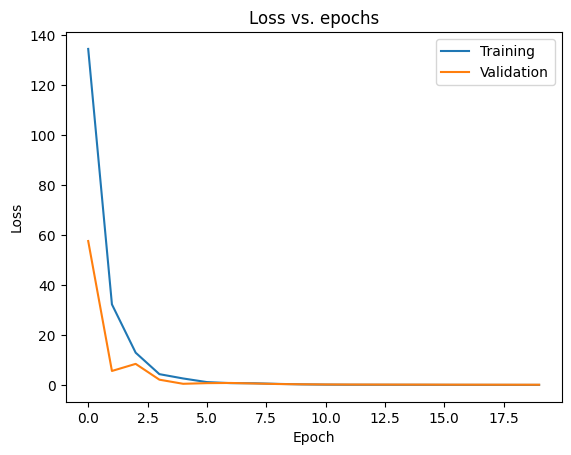

In [19]:
plt.plot(history_nn2.history['loss'])
plt.plot(history_nn2.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [20]:
get_test_accuracy(model_nn2, test_set_x.T, y_test)


accuracy: 0.963


In [21]:
model_nn3 = Sequential([#Flatten(input_shape = (64, 64, 3)),
Dense(24, activation = 'relu', input_shape = (12288,)),
Dense(1, activation = 'sigmoid')
])

model_nn3.compile(
optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
loss = 'binary_crossentropy',
metrics=[tf.keras.metrics.BinaryAccuracy()])

history_nn3 = model_nn3.fit(train_set_x, y_train, epochs = 20, batch_size = 256, verbose = 2, validation_data=(cv_x, y_cv))
df_nn3 = pd.DataFrame(history_nn3.history)
df_nn3

Epoch 1/20


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 1s - 232ms/step - binary_accuracy: 0.5585 - loss: 37.2495 - val_binary_accuracy: 0.8004 - val_loss: 8.3485
Epoch 2/20
6/6 - 0s - 19ms/step - binary_accuracy: 0.8268 - loss: 6.5905 - val_binary_accuracy: 0.8947 - val_loss: 3.9904
Epoch 3/20
6/6 - 0s - 18ms/step - binary_accuracy: 0.9218 - loss: 3.0789 - val_binary_accuracy: 0.9364 - val_loss: 2.1987
Epoch 4/20
6/6 - 0s - 19ms/step - binary_accuracy: 0.9364 - loss: 1.9202 - val_binary_accuracy: 0.9276 - val_loss: 2.4920
Epoch 5/20
6/6 - 0s - 21ms/step - binary_accuracy: 0.9423 - loss: 1.7288 - val_binary_accuracy: 0.9408 - val_loss: 2.0331
Epoch 6/20
6/6 - 0s - 19ms/step - binary_accuracy: 0.9547 - loss: 1.4778 - val_binary_accuracy: 0.9364 - val_loss: 1.9971
Epoch 7/20
6/6 - 0s - 21ms/step - binary_accuracy: 0.9547 - loss: 1.3956 - val_binary_accuracy: 0.9430 - val_loss: 1.8524
Epoch 8/20
6/6 - 0s - 19ms/step - binary_accuracy: 0.9576 - loss: 1.1771 - val_binary_accuracy: 0.9452 - val_loss: 1.7362
Epoch 9/20
6/6 - 0s - 20ms/step -

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.558480,37.249550,0.800439,8.348518
1,0.826754,6.590453,0.894737,3.990359
2,0.921784,3.078893,0.936404,2.198684
3,0.936404,1.920184,0.927632,2.491972
4,0.942251,1.728758,0.940789,2.033085
5,0.954678,1.477771,0.936404,1.997052
6,0.954678,1.395644,0.942982,1.852430
7,0.957602,1.177128,0.945175,1.736157
8,0.959795,1.045317,0.942982,1.595263
9,0.964912,0.930951,0.947368,1.599715


In [22]:
model_nn4 = Sequential([#Flatten(input_shape = (64, 64, 3)),
Dense(48, activation = 'relu', input_shape = (12288,)),
Dense(1, activation = 'sigmoid')
])

model_nn4.compile(
optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
loss = 'binary_crossentropy',
metrics=[tf.keras.metrics.BinaryAccuracy()])

history_nn4 = model_nn4.fit(train_set_x, y_train, epochs = 20, batch_size = 256, verbose = 2, validation_data=(cv_x, y_cv))
df_nn4 = pd.DataFrame(history_nn4.history)
df_nn4

Epoch 1/20


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 1s - 249ms/step - binary_accuracy: 0.5512 - loss: 107.2187 - val_binary_accuracy: 0.7807 - val_loss: 17.1692
Epoch 2/20
6/6 - 0s - 19ms/step - binary_accuracy: 0.6879 - loss: 41.0947 - val_binary_accuracy: 0.8662 - val_loss: 8.9181
Epoch 3/20
6/6 - 0s - 19ms/step - binary_accuracy: 0.8480 - loss: 13.5978 - val_binary_accuracy: 0.9035 - val_loss: 4.7786
Epoch 4/20
6/6 - 0s - 20ms/step - binary_accuracy: 0.8940 - loss: 5.3095 - val_binary_accuracy: 0.8860 - val_loss: 4.5098
Epoch 5/20
6/6 - 0s - 20ms/step - binary_accuracy: 0.9101 - loss: 3.3584 - val_binary_accuracy: 0.9364 - val_loss: 2.5982
Epoch 6/20
6/6 - 0s - 21ms/step - binary_accuracy: 0.9437 - loss: 2.2295 - val_binary_accuracy: 0.9364 - val_loss: 2.4401
Epoch 7/20
6/6 - 0s - 19ms/step - binary_accuracy: 0.9547 - loss: 1.6933 - val_binary_accuracy: 0.9452 - val_loss: 1.9344
Epoch 8/20
6/6 - 0s - 20ms/step - binary_accuracy: 0.9437 - loss: 1.4618 - val_binary_accuracy: 0.9364 - val_loss: 1.8906
Epoch 9/20
6/6 - 0s - 20ms/st

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.551170,107.218704,0.780702,17.169197
1,0.687865,41.094711,0.866228,8.918114
2,0.847953,13.597800,0.903509,4.778612
3,0.894006,5.309497,0.885965,4.509770
4,0.910088,3.358371,0.936404,2.598178
5,0.943713,2.229478,0.936404,2.440068
6,0.954678,1.693305,0.945175,1.934409
7,0.943713,1.461778,0.936404,1.890583
8,0.953947,1.184172,0.951754,1.455929
9,0.958333,1.013623,0.945175,1.284928


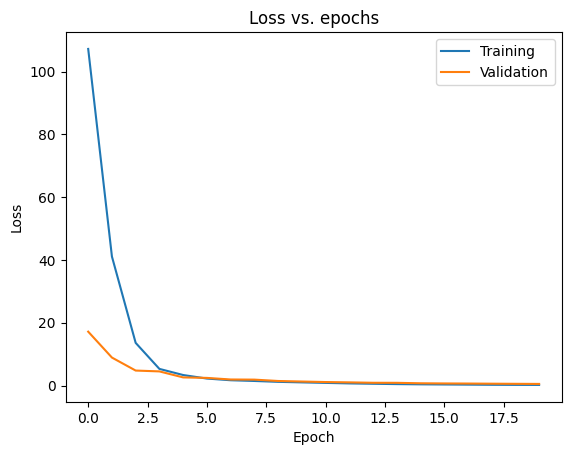

In [23]:
plt.plot(history_nn4.history['loss'])
plt.plot(history_nn4.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

#### 3 DIFFERENT OPTIMIZATIONS

In [24]:
# MODEL 1
# building a NN model
# the input layer with 16 units
# one hidden layer, with 64 units, with a relu activation function.
# the output layer is binary with a sigmoid activation function.
model = Sequential([#Flatten(input_shape = (64, 64, 3)),
Dense(64, activation = 'relu', input_shape = (12288,)),
Dense(48, activation='relu'),  # Additional hidden layer
Dense(1, activation = 'sigmoid')
])

c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 64)             │       786,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 48)             │         3,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 789,665 (3.01 MB)

 Trainable params: 789,665 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(
optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
loss = 'binary_crossentropy',
metrics=[tf.keras.metrics.BinaryAccuracy()])

history = model.fit(train_set_x, y_train, epochs = 20, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))
df = pd.DataFrame(history.history)
df

Epoch 1/20
6/6 - 2s - 283ms/step - binary_accuracy: 0.5541 - loss: 135.3885 - val_binary_accuracy: 0.5548 - val_loss: 38.5826
Epoch 2/20
6/6 - 0s - 21ms/step - binary_accuracy: 0.6798 - loss: 16.2143 - val_binary_accuracy: 0.8180 - val_loss: 4.5210
Epoch 3/20
6/6 - 0s - 20ms/step - binary_accuracy: 0.8523 - loss: 2.8535 - val_binary_accuracy: 0.8224 - val_loss: 3.3323
Epoch 4/20
6/6 - 0s - 20ms/step - binary_accuracy: 0.8348 - loss: 2.3277 - val_binary_accuracy: 0.9057 - val_loss: 0.5653
Epoch 5/20
6/6 - 0s - 19ms/step - binary_accuracy: 0.8713 - loss: 0.6416 - val_binary_accuracy: 0.9254 - val_loss: 0.4513
Epoch 6/20
6/6 - 0s - 20ms/step - binary_accuracy: 0.9335 - loss: 0.3721 - val_binary_accuracy: 0.9232 - val_loss: 0.3616
Epoch 7/20
6/6 - 0s - 20ms/step - binary_accuracy: 0.9408 - loss: 0.2122 - val_binary_accuracy: 0.9057 - val_loss: 0.3012
Epoch 8/20
6/6 - 0s - 21ms/step - binary_accuracy: 0.9225 - loss: 0.1989 - val_binary_accuracy: 0.9298 - val_loss: 0.2503
Epoch 9/20
6/6 - 0s

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.554094,135.388474,0.554825,38.582588
1,0.679825,16.214342,0.817982,4.520988
2,0.852339,2.853477,0.822368,3.332314
3,0.834795,2.327736,0.905702,0.565252
4,0.871345,0.641629,0.925439,0.451268
5,0.933480,0.372114,0.923246,0.361589
6,0.940789,0.212224,0.905702,0.301220
7,0.922515,0.198925,0.929825,0.250290
8,0.947368,0.174895,0.932018,0.241507
9,0.951754,0.168186,0.936404,0.228428


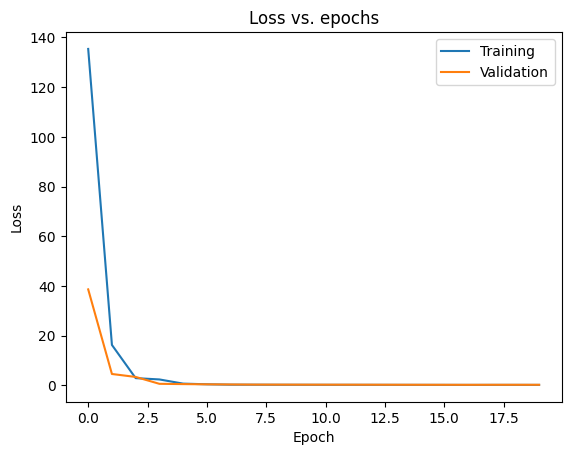

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


In [28]:
get_test_accuracy(model, test_set_x.T, y_test)


accuracy: 0.967


In [29]:
# model 2
model2 = Sequential([#Flatten(input_shape = (64, 64, 3)),
Dense(64, activation = 'relu', input_shape = (12288,)),
Dense(48, activation='relu'),  # Additional hidden layer
Dense(1, activation = 'sigmoid')
])

model2.compile(
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.050353614650626294),
loss = 'binary_crossentropy',
metrics=[tf.keras.metrics.BinaryAccuracy()])

history2 = model2.fit(train_set_x, y_train, epochs = 20, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df2 = pd.DataFrame(history2.history)
df2

Epoch 1/20


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 2s - 326ms/step - binary_accuracy: 0.4898 - loss: 308.5745 - val_binary_accuracy: 0.4715 - val_loss: 97.9607
Epoch 2/20
6/6 - 0s - 21ms/step - binary_accuracy: 0.5899 - loss: 37.6373 - val_binary_accuracy: 0.7281 - val_loss: 10.2539
Epoch 3/20
6/6 - 0s - 22ms/step - binary_accuracy: 0.7829 - loss: 5.4305 - val_binary_accuracy: 0.8596 - val_loss: 1.3210
Epoch 4/20
6/6 - 0s - 21ms/step - binary_accuracy: 0.8231 - loss: 1.4787 - val_binary_accuracy: 0.8618 - val_loss: 1.3325
Epoch 5/20
6/6 - 0s - 21ms/step - binary_accuracy: 0.8553 - loss: 1.2331 - val_binary_accuracy: 0.9211 - val_loss: 0.4531
Epoch 6/20
6/6 - 0s - 21ms/step - binary_accuracy: 0.8918 - loss: 0.5237 - val_binary_accuracy: 0.8969 - val_loss: 0.3705
Epoch 7/20
6/6 - 0s - 20ms/step - binary_accuracy: 0.9203 - loss: 0.2681 - val_binary_accuracy: 0.9211 - val_loss: 0.2683
Epoch 8/20
6/6 - 0s - 22ms/step - binary_accuracy: 0.9276 - loss: 0.2411 - val_binary_accuracy: 0.9254 - val_loss: 0.2395
Epoch 9/20
6/6 - 0s - 23ms/st

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.489766,308.574493,0.471491,97.960670
1,0.589912,37.637329,0.728070,10.253917
2,0.782895,5.430455,0.859649,1.320985
3,0.823099,1.478657,0.861842,1.332543
4,0.855263,1.233060,0.921053,0.453142
5,0.891813,0.523722,0.896930,0.370518
6,0.920322,0.268093,0.921053,0.268284
7,0.927632,0.241067,0.925439,0.239457
8,0.931287,0.203179,0.916667,0.233434
9,0.932749,0.191055,0.932018,0.209722


In [30]:
# model 2
model3 = Sequential([#Flatten(input_shape = (64, 64, 3)),
Dense(64, activation = 'relu', input_shape = (12288,)),
Dense(48, activation='relu'),  # Additional hidden layer
Dense(1, activation = 'sigmoid')
])

model3.compile(
optimizer = tf.keras.optimizers.Adagrad(learning_rate = 0.050353614650626294),
loss = 'binary_crossentropy',
metrics=[tf.keras.metrics.BinaryAccuracy()])

history3 = model3.fit(train_set_x, y_train, epochs = 20, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df3 = pd.DataFrame(history3.history)
df3

Epoch 1/20


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 1s - 217ms/step - binary_accuracy: 0.5431 - loss: 1.9707 - val_binary_accuracy: 0.8333 - val_loss: 0.4682
Epoch 2/20
6/6 - 0s - 21ms/step - binary_accuracy: 0.6067 - loss: 0.9201 - val_binary_accuracy: 0.5395 - val_loss: 0.5830
Epoch 3/20
6/6 - 0s - 19ms/step - binary_accuracy: 0.5950 - loss: 0.5583 - val_binary_accuracy: 0.5548 - val_loss: 0.5998
Epoch 4/20
6/6 - 0s - 19ms/step - binary_accuracy: 0.7858 - loss: 0.4370 - val_binary_accuracy: 0.5395 - val_loss: 0.8682
Epoch 5/20
6/6 - 0s - 21ms/step - binary_accuracy: 0.7434 - loss: 0.5100 - val_binary_accuracy: 0.8092 - val_loss: 0.3358
Epoch 6/20
6/6 - 0s - 21ms/step - binary_accuracy: 0.9035 - loss: 0.2312 - val_binary_accuracy: 0.9408 - val_loss: 0.1818
Epoch 7/20
6/6 - 0s - 21ms/step - binary_accuracy: 0.9532 - loss: 0.1629 - val_binary_accuracy: 0.9474 - val_loss: 0.1599
Epoch 8/20
6/6 - 0s - 20ms/step - binary_accuracy: 0.9320 - loss: 0.1929 - val_binary_accuracy: 0.9452 - val_loss: 0.1624
Epoch 9/20
6/6 - 0s - 20ms/step - 

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.543129,1.970683,0.833333,0.468220
1,0.606725,0.920102,0.539474,0.583040
2,0.595029,0.558267,0.554825,0.599787
3,0.785819,0.436998,0.539474,0.868196
4,0.743421,0.509983,0.809211,0.335792
5,0.903509,0.231213,0.940789,0.181833
6,0.953216,0.162881,0.947368,0.159933
7,0.932018,0.192932,0.945175,0.162444
8,0.961988,0.117972,0.949561,0.141340
9,0.962719,0.114758,0.951754,0.137458


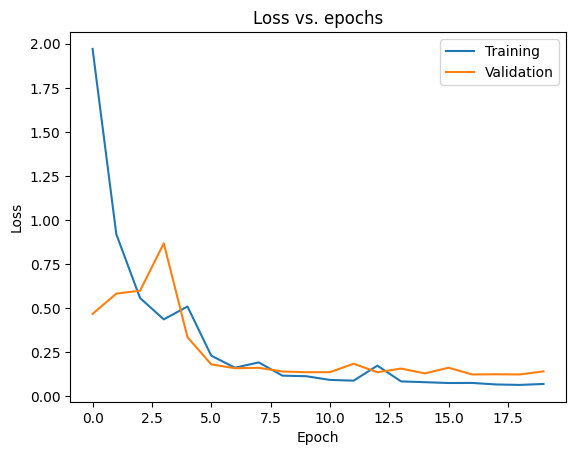

In [31]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

#### TESTING DIFFERENT EPOCHS

Epoch = 40

In [32]:
history_e1 = model.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))


Epoch 1/40
6/6 - 0s - 32ms/step - binary_accuracy: 0.9598 - loss: 0.1151 - val_binary_accuracy: 0.9320 - val_loss: 0.1728
Epoch 2/40
6/6 - 0s - 20ms/step - binary_accuracy: 0.9576 - loss: 0.1132 - val_binary_accuracy: 0.9320 - val_loss: 0.1703
Epoch 3/40
6/6 - 0s - 20ms/step - binary_accuracy: 0.9561 - loss: 0.1094 - val_binary_accuracy: 0.9342 - val_loss: 0.1488
Epoch 4/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9613 - loss: 0.0967 - val_binary_accuracy: 0.9386 - val_loss: 0.1513
Epoch 5/40
6/6 - 0s - 20ms/step - binary_accuracy: 0.9605 - loss: 0.0923 - val_binary_accuracy: 0.9276 - val_loss: 0.1483
Epoch 6/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9635 - loss: 0.0902 - val_binary_accuracy: 0.9408 - val_loss: 0.1430
Epoch 7/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9693 - loss: 0.0873 - val_binary_accuracy: 0.9364 - val_loss: 0.1433
Epoch 8/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9635 - loss: 0.0884 - val_binary_accuracy: 0.9430 - val_loss: 0.1417
Epoch 9/40
6/6 - 0s - 21

In [33]:
df_h1 = pd.DataFrame(history_e1.history)
df_h1.tail()


,binary_accuracy,loss,val_binary_accuracy,val_loss
35,0.991959,0.024936,0.962719,0.098409
36,0.992690,0.024181,0.960526,0.095252
37,0.994152,0.023385,0.958333,0.091456
38,0.993421,0.022020,0.964912,0.095809
39,0.995614,0.020715,0.967105,0.093924


Epoch = 30

In [34]:
history_e2 = model.fit(train_set_x, y_train, epochs = 30, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))


Epoch 1/30
6/6 - 0s - 37ms/step - binary_accuracy: 0.9942 - loss: 0.0199 - val_binary_accuracy: 0.9605 - val_loss: 0.0959
Epoch 2/30
6/6 - 0s - 22ms/step - binary_accuracy: 0.9963 - loss: 0.0194 - val_binary_accuracy: 0.9583 - val_loss: 0.0878
Epoch 3/30
6/6 - 0s - 22ms/step - binary_accuracy: 0.9942 - loss: 0.0192 - val_binary_accuracy: 0.9649 - val_loss: 0.0915
Epoch 4/30
6/6 - 0s - 21ms/step - binary_accuracy: 0.9963 - loss: 0.0176 - val_binary_accuracy: 0.9649 - val_loss: 0.0920
Epoch 5/30
6/6 - 0s - 21ms/step - binary_accuracy: 0.9963 - loss: 0.0166 - val_binary_accuracy: 0.9605 - val_loss: 0.0935
Epoch 6/30
6/6 - 0s - 22ms/step - binary_accuracy: 0.9963 - loss: 0.0161 - val_binary_accuracy: 0.9605 - val_loss: 0.0947
Epoch 7/30
6/6 - 0s - 25ms/step - binary_accuracy: 0.9956 - loss: 0.0157 - val_binary_accuracy: 0.9627 - val_loss: 0.0982
Epoch 8/30
6/6 - 0s - 21ms/step - binary_accuracy: 0.9956 - loss: 0.0150 - val_binary_accuracy: 0.9605 - val_loss: 0.0957
Epoch 9/30
6/6 - 0s - 21

In [35]:
df_h2 = pd.DataFrame(history_e2.history)
df_h2.tail()


,binary_accuracy,loss,val_binary_accuracy,val_loss
25,0.998538,0.006982,0.964912,0.101147
26,0.999269,0.007288,0.964912,0.089844
27,0.999269,0.007985,0.962719,0.109766
28,0.999269,0.006401,0.967105,0.090604
29,0.999269,0.006719,0.962719,0.114940


Epoch = 35

In [36]:
history_e3 = model.fit(train_set_x, y_train, epochs = 35, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))


Epoch 1/35
6/6 - 0s - 35ms/step - binary_accuracy: 0.9993 - loss: 0.0053 - val_binary_accuracy: 0.9649 - val_loss: 0.1016
Epoch 2/35
6/6 - 0s - 23ms/step - binary_accuracy: 1.0000 - loss: 0.0054 - val_binary_accuracy: 0.9649 - val_loss: 0.1031
Epoch 3/35
6/6 - 0s - 22ms/step - binary_accuracy: 1.0000 - loss: 0.0048 - val_binary_accuracy: 0.9671 - val_loss: 0.1085
Epoch 4/35
6/6 - 0s - 22ms/step - binary_accuracy: 0.9993 - loss: 0.0048 - val_binary_accuracy: 0.9649 - val_loss: 0.1057
Epoch 5/35
6/6 - 0s - 21ms/step - binary_accuracy: 1.0000 - loss: 0.0042 - val_binary_accuracy: 0.9649 - val_loss: 0.1046
Epoch 6/35
6/6 - 0s - 21ms/step - binary_accuracy: 1.0000 - loss: 0.0049 - val_binary_accuracy: 0.9649 - val_loss: 0.1065
Epoch 7/35
6/6 - 0s - 21ms/step - binary_accuracy: 0.9993 - loss: 0.0048 - val_binary_accuracy: 0.9671 - val_loss: 0.0981
Epoch 8/35
6/6 - 0s - 20ms/step - binary_accuracy: 1.0000 - loss: 0.0044 - val_binary_accuracy: 0.9649 - val_loss: 0.1208
Epoch 9/35
6/6 - 0s - 21

In [37]:
df_h3 = pd.DataFrame(history_e3.history)
df_h3.tail()

,binary_accuracy,loss,val_binary_accuracy,val_loss
30,1.0,0.001873,0.967105,0.107241
31,1.0,0.001820,0.964912,0.114770
32,1.0,0.001712,0.964912,0.117673
33,1.0,0.001654,0.964912,0.116349
34,1.0,0.001612,0.967105,0.115808


#### WEIGHT INITIALIZATION

In [38]:
model.weights

[<KerasVariable shape=(12288, 64), dtype=float32, path=sequential_4/dense_10/kernel>,
 <KerasVariable shape=(64,), dtype=float32, path=sequential_4/dense_10/bias>,
 <KerasVariable shape=(64, 48), dtype=float32, path=sequential_4/dense_11/kernel>,
 <KerasVariable shape=(48,), dtype=float32, path=sequential_4/dense_11/bias>,
 <KerasVariable shape=(48, 1), dtype=float32, path=sequential_4/dense_12/kernel>,
 <KerasVariable shape=(1,), dtype=float32, path=sequential_4/dense_12/bias>]

In [39]:
model_he = Sequential([
    Dense(64, kernel_initializer=tf.keras.initializers.HeUniform(seed = 3),
          bias_initializer=tf.keras.initializers.Constant(value=0.4), activation='relu',input_shape = (12288,)),
    Dense(48, kernel_initializer=tf.keras.initializers.HeUniform(seed = 3),
          bias_initializer=tf.keras.initializers.Constant(value=0.4), activation='relu'),      
    Dense(1, kernel_initializer=tf.keras.initializers.HeUniform(seed = 3),
          bias_initializer=tf.keras.initializers.Constant(value=0.4), activation='sigmoid')
])

model_he.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history_he = model_he.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df_he = pd.DataFrame(history_he.history)
df_he


Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 2s - 275ms/step - binary_accuracy: 0.5022 - loss: 185.3811 - val_binary_accuracy: 0.4715 - val_loss: 12.5061
Epoch 2/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.5461 - loss: 9.7847 - val_binary_accuracy: 0.8838 - val_loss: 0.4964
Epoch 3/40
6/6 - 0s - 20ms/step - binary_accuracy: 0.7551 - loss: 1.9272 - val_binary_accuracy: 0.8092 - val_loss: 1.7147
Epoch 4/40
6/6 - 0s - 20ms/step - binary_accuracy: 0.7822 - loss: 1.9986 - val_binary_accuracy: 0.8706 - val_loss: 0.6849
Epoch 5/40
6/6 - 0s - 20ms/step - binary_accuracy: 0.8801 - loss: 0.6495 - val_binary_accuracy: 0.8289 - val_loss: 0.9356
Epoch 6/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.8925 - loss: 0.6040 - val_binary_accuracy: 0.9101 - val_loss: 0.3731
Epoch 7/40
6/6 - 0s - 20ms/step - binary_accuracy: 0.8940 - loss: 0.4711 - val_binary_accuracy: 0.9013 - val_loss: 0.4855
Epoch 8/40
6/6 - 0s - 19ms/step - binary_accuracy: 0.9079 - loss: 0.3818 - val_binary_accuracy: 0.9189 - val_loss: 0.3078
Epoch 9/40
6/6 - 0s - 20ms/step

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.502193,185.381088,0.471491,12.506138
1,0.546053,9.784682,0.883772,0.496436
2,0.755117,1.927222,0.809211,1.714694
3,0.782164,1.998560,0.870614,0.684940
4,0.880117,0.649498,0.828947,0.935618
5,0.892544,0.603971,0.910088,0.373057
6,0.894006,0.471060,0.901316,0.485475
7,0.907895,0.381756,0.918860,0.307812
8,0.929094,0.292859,0.914474,0.314387
9,0.940789,0.241542,0.934211,0.252265


In [40]:
model_glo = Sequential([
    Dense(64, kernel_initializer=tf.keras.initializers.GlorotUniform(seed = 3),
          bias_initializer=tf.keras.initializers.Constant(value=0.4), activation='relu',input_shape = (12288,)),
    Dense(48, kernel_initializer=tf.keras.initializers.GlorotUniform(seed = 3),
          bias_initializer=tf.keras.initializers.Constant(value=0.4), activation='relu'),   
    Dense(1, kernel_initializer=tf.keras.initializers.GlorotUniform(seed = 3),
          bias_initializer=tf.keras.initializers.Constant(value=0.4), activation='sigmoid')
])

model_glo.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history_glo = model_glo.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df_glo = pd.DataFrame(history_glo.history)
df_glo

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 2s - 300ms/step - binary_accuracy: 0.5022 - loss: 156.3824 - val_binary_accuracy: 0.5285 - val_loss: 32.7112
Epoch 2/40
6/6 - 0s - 25ms/step - binary_accuracy: 0.6096 - loss: 23.2809 - val_binary_accuracy: 0.8224 - val_loss: 7.0764
Epoch 3/40
6/6 - 0s - 26ms/step - binary_accuracy: 0.7880 - loss: 10.2119 - val_binary_accuracy: 0.8991 - val_loss: 3.5254
Epoch 4/40
6/6 - 0s - 24ms/step - binary_accuracy: 0.8889 - loss: 4.4810 - val_binary_accuracy: 0.9057 - val_loss: 2.2268
Epoch 5/40
6/6 - 0s - 26ms/step - binary_accuracy: 0.8743 - loss: 2.8074 - val_binary_accuracy: 0.9342 - val_loss: 1.8395
Epoch 6/40
6/6 - 0s - 29ms/step - binary_accuracy: 0.9364 - loss: 1.8166 - val_binary_accuracy: 0.9430 - val_loss: 1.9643
Epoch 7/40
6/6 - 0s - 20ms/step - binary_accuracy: 0.9225 - loss: 1.4583 - val_binary_accuracy: 0.9408 - val_loss: 1.5775
Epoch 8/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9569 - loss: 0.9378 - val_binary_accuracy: 0.9430 - val_loss: 1.4895
Epoch 9/40
6/6 - 0s - 22ms/st

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.502193,156.382446,0.528509,32.711159
1,0.609649,23.280886,0.822368,7.076355
2,0.788012,10.211886,0.899123,3.525421
3,0.888889,4.480951,0.905702,2.226835
4,0.874269,2.807415,0.934211,1.839518
5,0.936404,1.816643,0.942982,1.964334
6,0.922515,1.458332,0.940789,1.577458
7,0.956871,0.937832,0.942982,1.489484
8,0.950292,0.699772,0.942982,0.997622
9,0.956140,0.814078,0.960526,0.815566


In [41]:
model_ru = Sequential([
    Dense(64, kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4),
                activation='relu',input_shape = (12288,)),
    Dense(48, kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4), activation='relu'),   
    Dense(1, kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
          bias_initializer=tf.keras.initializers.Constant(value=0.4), activation='sigmoid')
])


model_ru.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history_ru = model_ru.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df_ru = pd.DataFrame(history_ru.history)
df_ru

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 2s - 283ms/step - binary_accuracy: 0.4846 - loss: 69.6753 - val_binary_accuracy: 0.4715 - val_loss: 192.6669
Epoch 2/40
6/6 - 0s - 35ms/step - binary_accuracy: 0.5395 - loss: 88.5339 - val_binary_accuracy: 0.8596 - val_loss: 0.3975
Epoch 3/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.5694 - loss: 0.6578 - val_binary_accuracy: 0.4715 - val_loss: 0.7255
Epoch 4/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.4963 - loss: 0.7103 - val_binary_accuracy: 0.4715 - val_loss: 0.7062
Epoch 5/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.4963 - loss: 0.6983 - val_binary_accuracy: 0.4715 - val_loss: 0.6985
Epoch 6/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.4963 - loss: 0.6948 - val_binary_accuracy: 0.4715 - val_loss: 0.6943
Epoch 7/40
6/6 - 0s - 24ms/step - binary_accuracy: 0.4934 - loss: 0.6934 - val_binary_accuracy: 0.5285 - val_loss: 0.6928
Epoch 8/40
6/6 - 0s - 27ms/step - binary_accuracy: 0.5037 - loss: 0.6933 - val_binary_accuracy: 0.5285 - val_loss: 0.6923
Epoch 9/40
6/6 - 0s - 22ms/ste

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.484649,69.675301,0.471491,192.666870
1,0.539474,88.533852,0.859649,0.397472
2,0.569444,0.657765,0.471491,0.725498
3,0.496345,0.710254,0.471491,0.706228
4,0.496345,0.698263,0.471491,0.698497
5,0.496345,0.694846,0.471491,0.694285
6,0.493421,0.693364,0.528509,0.692789
7,0.503655,0.693327,0.528509,0.692263
8,0.503655,0.693175,0.528509,0.692361
9,0.503655,0.693114,0.528509,0.692642


In [42]:
get_test_accuracy(model_ru, test_set_x.T, y_test)


accuracy: 0.531


### PART 3: FIT VALIDATION

Check for overfitting on best model so far

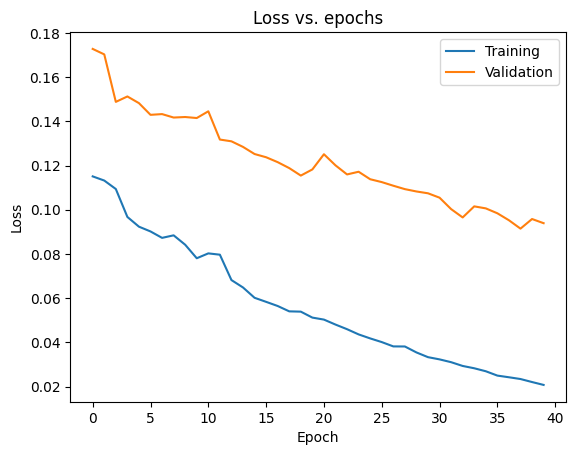

In [43]:
plt.plot(history_e1.history['loss'])
plt.plot(history_e1.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

#### L2 Regularization

L2 REGULARIZATION - Penalty Rate 0.002

In [44]:
modelL2 = Sequential([#Flatten(input_shape = (64, 64, 3)),
                     Dense(64, activation='relu',input_shape = (12288,),kernel_regularizer=tf.keras.regularizers.l2(0.002)),
                    Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.002)), 
                    Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.002))
])

modelL2.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

historyL2 = modelL2.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

dfL2 = pd.DataFrame(historyL2.history)
dfL2

c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
6/6 - 2s - 330ms/step - binary_accuracy: 0.5687 - loss: 77.5009 - val_binary_accuracy: 0.8772 - val_loss: 11.0545
Epoch 2/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.8779 - loss: 12.0882 - val_binary_accuracy: 0.8947 - val_loss: 12.0247
Epoch 3/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.9057 - loss: 11.8714 - val_binary_accuracy: 0.9430 - val_loss: 10.8476
Epoch 4/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9466 - loss: 10.2838 - val_binary_accuracy: 0.9474 - val_loss: 9.5730
Epoch 5/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.9532 - loss: 8.8116 - val_binary_accuracy: 0.8925 - val_loss: 8.6014
Epoch 6/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.9415 - loss: 7.6967 - val_binary_accuracy: 0.7961 - val_loss: 8.0250
Epoch 7/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.9108 - loss: 6.9203 - val_binary_accuracy: 0.9452 - val_loss: 6.3120
Epoch 8/40
6/6 - 0s - 24ms/step - binary_accuracy: 0.9481 - loss: 5.8669 - val_binary_accuracy: 0.9364 - val_loss: 5.5939
Epoch 9/40
6/6 -

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.568713,77.500946,0.877193,11.054540
1,0.877924,12.088163,0.894737,12.024737
2,0.905702,11.871367,0.942982,10.847569
3,0.946637,10.283791,0.947368,9.572973
4,0.953216,8.811644,0.892544,8.601402
5,0.941520,7.696733,0.796053,8.024966
6,0.910819,6.920317,0.945175,6.312004
7,0.948099,5.866872,0.936404,5.593880
8,0.961988,5.169750,0.927632,5.065873
9,0.959795,4.567506,0.942982,4.313213


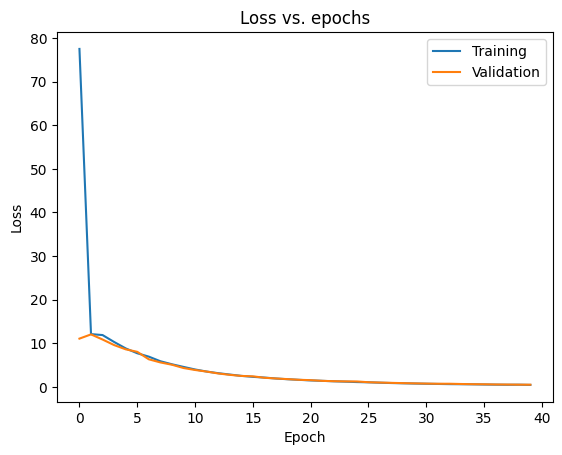

In [45]:
plt.plot(historyL2.history['loss'])
plt.plot(historyL2.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [46]:
get_test_accuracy(modelL2, test_set_x.T, y_test)


accuracy: 0.982


L2 REGULARIZATION - Penalty Rate 0.003

In [47]:
modelL2_2 = Sequential([#Flatten(input_shape = (64, 64, 3)),
                     Dense(64, activation='relu',input_shape = (12288,),kernel_regularizer=tf.keras.regularizers.l2(0.003)),
                    Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.003)), 
                    Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.003))
])

modelL2_2.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

historyL2_2 = modelL2_2.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 2s - 342ms/step - binary_accuracy: 0.5848 - loss: 257.7785 - val_binary_accuracy: 0.5285 - val_loss: 47.8823
Epoch 2/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.6374 - loss: 27.0520 - val_binary_accuracy: 0.7368 - val_loss: 19.3915
Epoch 3/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.8355 - loss: 16.9153 - val_binary_accuracy: 0.8816 - val_loss: 15.1565
Epoch 4/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.8648 - loss: 15.1843 - val_binary_accuracy: 0.9232 - val_loss: 14.4092
Epoch 5/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9401 - loss: 13.6578 - val_binary_accuracy: 0.9342 - val_loss: 12.9108
Epoch 6/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9518 - loss: 12.0698 - val_binary_accuracy: 0.9452 - val_loss: 11.4272
Epoch 7/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9598 - loss: 10.6666 - val_binary_accuracy: 0.9474 - val_loss: 10.0768
Epoch 8/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9591 - loss: 9.4501 - val_binary_accuracy: 0.9496 - val_loss: 8.9681
Epoch 9/40
6/6 - 0s

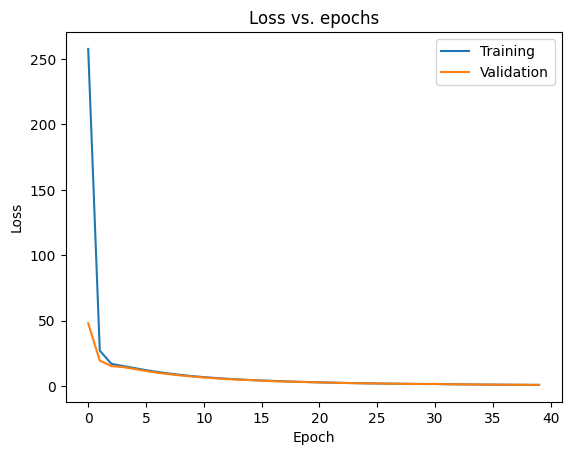

In [48]:
plt.plot(historyL2_2.history['loss'])
plt.plot(historyL2_2.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

L2 REGULARIZATION - Penalty Rate 0.1

In [49]:
modelL2_3 = Sequential([#Flatten(input_shape = (64, 64, 3)),
                     Dense(64, activation='relu',input_shape = (12288,),kernel_regularizer=tf.keras.regularizers.l2(0.1)),
                    Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)), 
                    Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.1))
])

modelL2_3.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

historyL2_3 = modelL2_3.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df2_3 = pd.DataFrame(historyL2_3.history)
df2_3

Epoch 1/40
6/6 - 2s - 330ms/step - binary_accuracy: 0.4868 - loss: 133.3384 - val_binary_accuracy: 0.4715 - val_loss: 73.6223
Epoch 2/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.6133 - loss: 52.9572 - val_binary_accuracy: 0.6184 - val_loss: 36.3986
Epoch 3/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.6155 - loss: 28.3279 - val_binary_accuracy: 0.5724 - val_loss: 15.8635
Epoch 4/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.7200 - loss: 13.8410 - val_binary_accuracy: 0.8355 - val_loss: 10.1554
Epoch 5/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.6535 - loss: 10.3547 - val_binary_accuracy: 0.8750 - val_loss: 8.5647
Epoch 6/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.8977 - loss: 7.7873 - val_binary_accuracy: 0.9167 - val_loss: 5.4369
Epoch 7/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9189 - loss: 4.7306 - val_binary_accuracy: 0.9320 - val_loss: 3.7966
Epoch 8/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.8947 - loss: 3.3853 - val_binary_accuracy: 0.8991 - val_loss: 2.8155
Epoch 9/40
6/

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.486842,133.338364,0.471491,73.622307
1,0.613304,52.957180,0.618421,36.398636
2,0.615497,28.327860,0.572368,15.863531
3,0.720029,13.840969,0.835526,10.155401
4,0.653509,10.354695,0.875000,8.564673
5,0.897661,7.787309,0.916667,5.436928
6,0.918860,4.730588,0.932018,3.796641
7,0.894737,3.385299,0.899123,2.815495
8,0.822368,2.996224,0.550439,3.001424
9,0.751462,2.792290,0.940789,2.505333


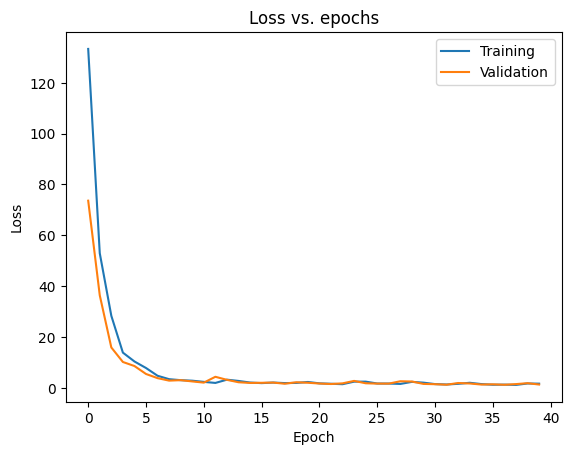

In [50]:
plt.plot(historyL2_3.history['loss'])
plt.plot(historyL2_3.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

L2 REGULARIZATION - Penalty Rate 0.001

In [51]:
modelL2_4 = Sequential([#Flatten(input_shape = (64, 64, 3)),
                     Dense(64, activation='relu',input_shape = (12288,),kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)), 
                    Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

modelL2_4.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

historyL2_4 = modelL2_4.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df2_4 = pd.DataFrame(historyL2_4.history)
df2_4

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 2s - 314ms/step - binary_accuracy: 0.5994 - loss: 69.6905 - val_binary_accuracy: 0.8158 - val_loss: 8.0724
Epoch 2/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.8648 - loss: 7.3945 - val_binary_accuracy: 0.9298 - val_loss: 6.2434
Epoch 3/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9342 - loss: 5.9751 - val_binary_accuracy: 0.9320 - val_loss: 6.0165
Epoch 4/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9503 - loss: 5.5896 - val_binary_accuracy: 0.9452 - val_loss: 5.3977
Epoch 5/40
6/6 - 0s - 36ms/step - binary_accuracy: 0.9605 - loss: 4.9700 - val_binary_accuracy: 0.9364 - val_loss: 4.8164
Epoch 6/40
6/6 - 0s - 24ms/step - binary_accuracy: 0.9627 - loss: 4.5055 - val_binary_accuracy: 0.9539 - val_loss: 4.3212
Epoch 7/40
6/6 - 0s - 24ms/step - binary_accuracy: 0.9810 - loss: 4.0287 - val_binary_accuracy: 0.9627 - val_loss: 3.9229
Epoch 8/40
6/6 - 0s - 24ms/step - binary_accuracy: 0.9737 - loss: 3.6548 - val_binary_accuracy: 0.9539 - val_loss: 3.5662
Epoch 9/40
6/6 - 0s - 21ms/step -

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.599415,69.690468,0.815789,8.072395
1,0.864766,7.394483,0.929825,6.243408
2,0.934211,5.975107,0.932018,6.016506
3,0.950292,5.589573,0.945175,5.397685
4,0.960526,4.970037,0.936404,4.816406
5,0.962719,4.505491,0.953947,4.321229
6,0.980994,4.028652,0.962719,3.922852
7,0.973684,3.654835,0.953947,3.566188
8,0.978801,3.324357,0.947368,3.244020
9,0.981725,3.024363,0.945175,3.007546


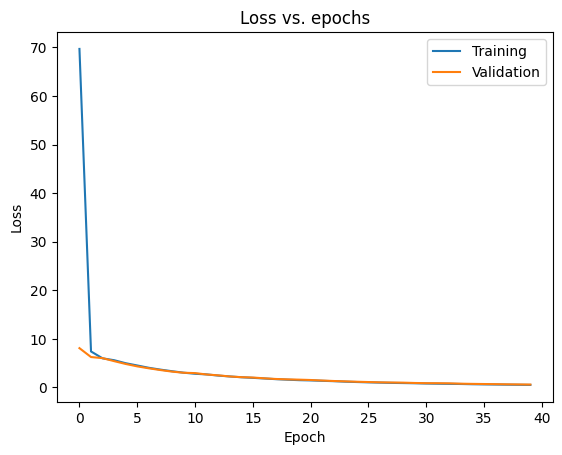

In [52]:
plt.plot(historyL2_4.history['loss'])
plt.plot(historyL2_4.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

L2 REGULARIZATION - Penalty Rate 0.05

In [53]:
modelL2_5 = Sequential([#Flatten(input_shape = (64, 64, 3)),
                     Dense(64, activation='relu',input_shape = (12288,),kernel_regularizer=tf.keras.regularizers.l2(0.05)),
                    Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.05)), 
                    Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.05))
])

modelL2_5.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

historyL2_5 = modelL2_5.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df2_5 = pd.DataFrame(historyL2_5.history)
df2_5

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 2s - 400ms/step - binary_accuracy: 0.5702 - loss: 94.1022 - val_binary_accuracy: 0.9013 - val_loss: 36.8534
Epoch 2/40
6/6 - 0s - 64ms/step - binary_accuracy: 0.6652 - loss: 28.6730 - val_binary_accuracy: 0.9320 - val_loss: 17.0962
Epoch 3/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.8596 - loss: 14.0324 - val_binary_accuracy: 0.4825 - val_loss: 9.9844
Epoch 4/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.5702 - loss: 9.0488 - val_binary_accuracy: 0.7588 - val_loss: 6.9583
Epoch 5/40
6/6 - 0s - 25ms/step - binary_accuracy: 0.7478 - loss: 5.8373 - val_binary_accuracy: 0.8246 - val_loss: 3.8654
Epoch 6/40
6/6 - 0s - 24ms/step - binary_accuracy: 0.8699 - loss: 3.2158 - val_binary_accuracy: 0.9320 - val_loss: 2.3492
Epoch 7/40
6/6 - 0s - 24ms/step - binary_accuracy: 0.8523 - loss: 2.2222 - val_binary_accuracy: 0.8618 - val_loss: 1.9568
Epoch 8/40
6/6 - 0s - 25ms/step - binary_accuracy: 0.8911 - loss: 1.7954 - val_binary_accuracy: 0.8947 - val_loss: 1.5898
Epoch 9/40
6/6 - 0s - 22ms/st

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.570175,94.102211,0.901316,36.853397
1,0.665205,28.672985,0.932018,17.096174
2,0.859649,14.032405,0.482456,9.984385
3,0.570175,9.048845,0.758772,6.958334
4,0.747807,5.837348,0.824561,3.865376
5,0.869883,3.215844,0.932018,2.349234
6,0.852339,2.222240,0.861842,1.956847
7,0.891082,1.795396,0.894737,1.589772
8,0.945906,1.399317,0.936404,1.252180
9,0.964181,1.112919,0.927632,1.075737


#### Drop out regularization

DROP OUT REGULARIZATION - Dropout Rate 0.2 all layers

In [54]:
model_dr = Sequential([#Flatten(input_shape = (64, 64, 3)),
                     Dense(64, activation='relu',input_shape = (12288,)),
                     Dropout(0.2),
                    Dense(48, activation='relu'), 
                    Dropout(0.2),
                    Dense(1, activation='sigmoid')
])

model_dr.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history_dr = model_dr.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df_dr = pd.DataFrame(history_dr.history)
df_dr

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 2s - 312ms/step - binary_accuracy: 0.5482 - loss: 207.1017 - val_binary_accuracy: 0.5285 - val_loss: 65.0723
Epoch 2/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.5687 - loss: 32.8139 - val_binary_accuracy: 0.5263 - val_loss: 8.4125
Epoch 3/40
6/6 - 0s - 32ms/step - binary_accuracy: 0.6871 - loss: 6.5206 - val_binary_accuracy: 0.8180 - val_loss: 1.6071
Epoch 4/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.7953 - loss: 1.9812 - val_binary_accuracy: 0.9035 - val_loss: 0.7602
Epoch 5/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.8436 - loss: 1.0511 - val_binary_accuracy: 0.8991 - val_loss: 0.3677
Epoch 6/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.8289 - loss: 0.6209 - val_binary_accuracy: 0.8202 - val_loss: 0.3670
Epoch 7/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.8319 - loss: 0.4686 - val_binary_accuracy: 0.9079 - val_loss: 0.2279
Epoch 8/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.8699 - loss: 0.3445 - val_binary_accuracy: 0.9123 - val_loss: 0.2156
Epoch 9/40
6/6 - 0s - 21ms/ste

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.548246,207.101746,0.528509,65.072258
1,0.568713,32.813931,0.526316,8.412533
2,0.687135,6.520636,0.817982,1.607143
3,0.795322,1.981167,0.903509,0.760186
4,0.843567,1.051121,0.899123,0.367725
5,0.828947,0.620944,0.820175,0.367024
6,0.831871,0.468612,0.907895,0.227853
7,0.869883,0.344505,0.912281,0.215625
8,0.856725,0.319997,0.914474,0.234532
9,0.873538,0.286721,0.925439,0.217718


DROP OUT REGULARIZATION - Dropout Rate 0.1 all layers

In [55]:
model_dr2 = Sequential([#Flatten(input_shape = (64, 64, 3)),
                     Dense(64, activation='relu',input_shape = (12288,)),
                     Dropout(0.1),
                    Dense(48, activation='relu'), 
                    Dropout(0.1),
                    Dense(1, activation='sigmoid')
])

model_dr2.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history_dr2 = model_dr2.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df_dr2 = pd.DataFrame(history_dr2.history)
df_dr2

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 2s - 317ms/step - binary_accuracy: 0.5461 - loss: 136.0684 - val_binary_accuracy: 0.5044 - val_loss: 15.0343
Epoch 2/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.7178 - loss: 9.2558 - val_binary_accuracy: 0.7873 - val_loss: 4.9008
Epoch 3/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.8472 - loss: 2.3847 - val_binary_accuracy: 0.8662 - val_loss: 1.2776
Epoch 4/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.8779 - loss: 1.2276 - val_binary_accuracy: 0.9298 - val_loss: 0.3010
Epoch 5/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.8575 - loss: 0.5917 - val_binary_accuracy: 0.9430 - val_loss: 0.2117
Epoch 6/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9057 - loss: 0.4803 - val_binary_accuracy: 0.9232 - val_loss: 0.2733
Epoch 7/40
6/6 - 0s - 35ms/step - binary_accuracy: 0.9232 - loss: 0.3254 - val_binary_accuracy: 0.9276 - val_loss: 0.2028
Epoch 8/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9050 - loss: 0.3426 - val_binary_accuracy: 0.9342 - val_loss: 0.2058
Epoch 9/40
6/6 - 0s - 22ms/step

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.546053,136.068436,0.504386,15.034286
1,0.717836,9.255754,0.787281,4.900808
2,0.847222,2.384672,0.866228,1.277582
3,0.877924,1.227555,0.929825,0.300989
4,0.857456,0.591655,0.942982,0.211693
5,0.905702,0.480319,0.923246,0.273343
6,0.923246,0.325420,0.927632,0.202816
7,0.904971,0.342602,0.934211,0.205810
8,0.921053,0.245381,0.934211,0.200004
9,0.937865,0.237763,0.936404,0.194928


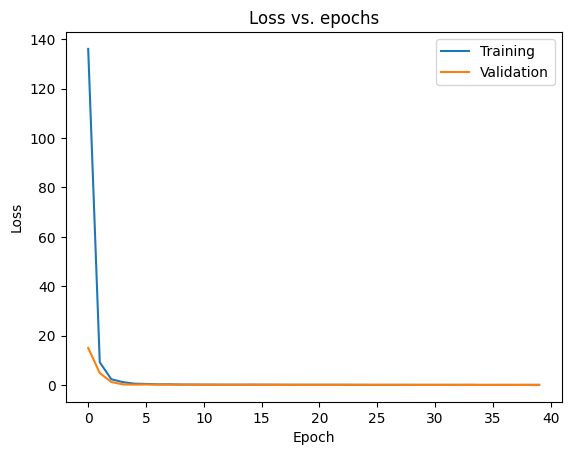

In [56]:
plt.plot(history_dr2.history['loss'])
plt.plot(history_dr2.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [57]:
get_test_accuracy(model_dr2, test_set_x.T, y_test)


accuracy: 0.987


DROP OUT REGULARIZATION - Dropout Rate 0.2 first hidden layer, 0.1 second hidden layer

In [58]:
model_dr3 = Sequential([#Flatten(input_shape = (64, 64, 3)),
                     Dense(64, activation='relu',input_shape = (12288,)),
                     Dropout(0.2),
                    Dense(48, activation='relu'), 
                    Dropout(0.1),
                    Dense(1, activation='sigmoid')
])

model_dr3.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history_dr3 = model_dr3.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df_dr3 = pd.DataFrame(history_dr3.history)
df_dr3

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 2s - 328ms/step - binary_accuracy: 0.4876 - loss: 201.8347 - val_binary_accuracy: 0.5373 - val_loss: 35.7204
Epoch 2/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.6367 - loss: 16.5480 - val_binary_accuracy: 0.4715 - val_loss: 0.7283
Epoch 3/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.5607 - loss: 1.9749 - val_binary_accuracy: 0.4715 - val_loss: 0.6573
Epoch 4/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.5746 - loss: 0.7128 - val_binary_accuracy: 0.7610 - val_loss: 0.6029
Epoch 5/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.7039 - loss: 0.7477 - val_binary_accuracy: 0.7105 - val_loss: 0.6093
Epoch 6/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.7135 - loss: 0.6420 - val_binary_accuracy: 0.6974 - val_loss: 0.6017
Epoch 7/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.7325 - loss: 0.5943 - val_binary_accuracy: 0.7610 - val_loss: 0.5539
Epoch 8/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.7478 - loss: 0.5551 - val_binary_accuracy: 0.7917 - val_loss: 0.5178
Epoch 9/40
6/6 - 0s - 22ms/ste

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.487573,201.834747,0.537281,35.720417
1,0.636696,16.548033,0.471491,0.728337
2,0.560673,1.974916,0.471491,0.657321
3,0.574561,0.712768,0.760965,0.602927
4,0.703947,0.747703,0.710526,0.609317
5,0.713450,0.642028,0.697368,0.601737
6,0.732456,0.594303,0.760965,0.553923
7,0.747807,0.555052,0.791667,0.517840
8,0.761696,0.532650,0.793860,0.506762
9,0.768275,0.517174,0.793860,0.499206


DROP OUT REGULARIZATION - Dropout Rate 0.1 first hidden layer, 0.2 second hidden layer

In [59]:
model_dr4 = Sequential([#Flatten(input_shape = (64, 64, 3)),
                     Dense(64, activation='relu',input_shape = (12288,)),
                     Dropout(0.1),
                    Dense(48, activation='relu'), 
                    Dropout(0.2),
                    Dense(1, activation='sigmoid')
])

model_dr4.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history_dr4 = model_dr4.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df_dr4 = pd.DataFrame(history_dr4.history)
df_dr4

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 2s - 323ms/step - binary_accuracy: 0.5080 - loss: 175.8882 - val_binary_accuracy: 0.5285 - val_loss: 26.0923
Epoch 2/40
6/6 - 0s - 36ms/step - binary_accuracy: 0.6652 - loss: 14.4306 - val_binary_accuracy: 0.8465 - val_loss: 4.7855
Epoch 3/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.8238 - loss: 5.6251 - val_binary_accuracy: 0.8882 - val_loss: 3.0066
Epoch 4/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.8538 - loss: 3.1080 - val_binary_accuracy: 0.9430 - val_loss: 0.7758
Epoch 5/40
6/6 - 0s - 24ms/step - binary_accuracy: 0.8933 - loss: 1.2839 - val_binary_accuracy: 0.9430 - val_loss: 0.2778
Epoch 6/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.9057 - loss: 0.5522 - val_binary_accuracy: 0.9079 - val_loss: 0.2615
Epoch 7/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.8889 - loss: 0.4184 - val_binary_accuracy: 0.9211 - val_loss: 0.2408
Epoch 8/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9028 - loss: 0.2707 - val_binary_accuracy: 0.9123 - val_loss: 0.2351
Epoch 9/40
6/6 - 0s - 22ms/ste

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.508041,175.888229,0.528509,26.092272
1,0.665205,14.430641,0.846491,4.785539
2,0.823830,5.625150,0.888158,3.006613
3,0.853801,3.107956,0.942982,0.775812
4,0.893275,1.283931,0.942982,0.277750
5,0.905702,0.552183,0.907895,0.261469
6,0.888889,0.418410,0.921053,0.240787
7,0.902778,0.270689,0.912281,0.235132
8,0.905702,0.296672,0.921053,0.219223
9,0.886696,0.301956,0.927632,0.215159


DROP OUT REGULARIZATION - Dropout Rate 0.25 all layers

In [60]:
model_dr5 = Sequential([#Flatten(input_shape = (64, 64, 3)),
                     Dense(64, activation='relu',input_shape = (12288,)),
                     Dropout(0.25),
                    Dense(48, activation='relu'), 
                    Dropout(0.25),
                    Dense(1, activation='sigmoid')
])

model_dr5.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history_dr5 = model_dr5.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df_dr5 = pd.DataFrame(history_dr5.history)
df_dr5

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 2s - 322ms/step - binary_accuracy: 0.5636 - loss: 153.5634 - val_binary_accuracy: 0.5285 - val_loss: 32.1222
Epoch 2/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.5548 - loss: 18.0567 - val_binary_accuracy: 0.4715 - val_loss: 5.3567
Epoch 3/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.5950 - loss: 2.3105 - val_binary_accuracy: 0.4737 - val_loss: 0.6950
Epoch 4/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.5782 - loss: 0.7723 - val_binary_accuracy: 0.4715 - val_loss: 0.6938
Epoch 5/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.5731 - loss: 0.7377 - val_binary_accuracy: 0.4715 - val_loss: 0.6927
Epoch 6/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.5738 - loss: 0.7300 - val_binary_accuracy: 0.4737 - val_loss: 0.6726
Epoch 7/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.5716 - loss: 0.6569 - val_binary_accuracy: 0.4825 - val_loss: 0.5969
Epoch 8/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.6016 - loss: 0.6264 - val_binary_accuracy: 0.5154 - val_loss: 0.6155
Epoch 9/40
6/6 - 0s - 21ms/ste

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.563596,153.563400,0.528509,32.122181
1,0.554825,18.056665,0.471491,5.356693
2,0.595029,2.310505,0.473684,0.694989
3,0.578216,0.772271,0.471491,0.693774
4,0.573099,0.737654,0.471491,0.692745
5,0.573830,0.729986,0.473684,0.672647
6,0.571637,0.656891,0.482456,0.596867
7,0.601608,0.626371,0.515351,0.615522
8,0.581871,0.657303,0.576754,0.525262
9,0.604532,0.568567,0.712719,0.476091


#### Combination L2 & Dropout 

Combination L2 & Dropout - 0.002 Penalty Rate and 0.1 Dropout Rate 

In [61]:
model_LD = Sequential([#Flatten(input_shape = (64, 64, 3)),
                     Dense(64, activation='relu',input_shape = (12288,),kernel_regularizer=tf.keras.regularizers.l2(0.002)),
                     Dropout(0.1),
                    Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.002)), 
                    Dropout(0.1),
                    Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.002))
])

model_LD.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history_LD = model_LD.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df_LD = pd.DataFrame(history_LD.history)
df_LD

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 2s - 346ms/step - binary_accuracy: 0.6023 - loss: 127.0240 - val_binary_accuracy: 0.8904 - val_loss: 10.0177
Epoch 2/40
6/6 - 0s - 31ms/step - binary_accuracy: 0.8428 - loss: 11.2996 - val_binary_accuracy: 0.8947 - val_loss: 9.8793
Epoch 3/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.8604 - loss: 10.0753 - val_binary_accuracy: 0.8991 - val_loss: 9.4925
Epoch 4/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9101 - loss: 8.8136 - val_binary_accuracy: 0.9386 - val_loss: 7.9969
Epoch 5/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9276 - loss: 7.6501 - val_binary_accuracy: 0.9430 - val_loss: 7.0043
Epoch 6/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9488 - loss: 6.6022 - val_binary_accuracy: 0.9408 - val_loss: 6.1268
Epoch 7/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9525 - loss: 5.8439 - val_binary_accuracy: 0.9430 - val_loss: 5.4746
Epoch 8/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9503 - loss: 5.2373 - val_binary_accuracy: 0.9496 - val_loss: 4.9520
Epoch 9/40
6/6 - 0s - 21ms/st

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.602339,127.024017,0.890351,10.017708
1,0.842836,11.299568,0.894737,9.879310
2,0.860380,10.075313,0.899123,9.492467
3,0.910088,8.813607,0.938596,7.996880
4,0.927632,7.650107,0.942982,7.004307
5,0.948830,6.602189,0.940789,6.126779
6,0.952485,5.843946,0.942982,5.474557
7,0.950292,5.237322,0.949561,4.951972
8,0.947368,4.726565,0.945175,4.464812
9,0.961988,4.286139,0.956140,4.111164


Combination L2 & Dropout - 0.002 Penalty Rate and 0.2 Dropout Rate 

In [62]:
model_LD2 = Sequential([#Flatten(input_shape = (64, 64, 3)),
                     Dense(64, activation='relu',input_shape = (12288,),kernel_regularizer=tf.keras.regularizers.l2(0.002)),
                     Dropout(0.2),
                    Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.002)), 
                    Dropout(0.2),
                    Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.002))
])

model_LD2.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history_LD2 = model_LD2.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df_LD2 = pd.DataFrame(history_LD2.history)
df_LD2

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 2s - 351ms/step - binary_accuracy: 0.5848 - loss: 62.1250 - val_binary_accuracy: 0.7368 - val_loss: 33.8089
Epoch 2/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.7822 - loss: 22.7809 - val_binary_accuracy: 0.9145 - val_loss: 12.8939
Epoch 3/40
6/6 - 0s - 24ms/step - binary_accuracy: 0.8494 - loss: 13.6454 - val_binary_accuracy: 0.9123 - val_loss: 10.9042
Epoch 4/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.8838 - loss: 10.7828 - val_binary_accuracy: 0.9189 - val_loss: 9.0724
Epoch 5/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.8596 - loss: 8.6986 - val_binary_accuracy: 0.9057 - val_loss: 7.7507
Epoch 6/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.8977 - loss: 7.4906 - val_binary_accuracy: 0.9189 - val_loss: 6.7093
Epoch 7/40
6/6 - 0s - 32ms/step - binary_accuracy: 0.9284 - loss: 6.3318 - val_binary_accuracy: 0.9167 - val_loss: 5.8318
Epoch 8/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9196 - loss: 5.5414 - val_binary_accuracy: 0.9320 - val_loss: 5.1042
Epoch 9/40
6/6 - 0s - 21ms/

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.584795,62.125050,0.736842,33.808918
1,0.782164,22.780945,0.914474,12.893876
2,0.849415,13.645364,0.912281,10.904244
3,0.883772,10.782759,0.918860,9.072450
4,0.859649,8.698621,0.905702,7.750740
5,0.897661,7.490571,0.918860,6.709260
6,0.928363,6.331816,0.916667,5.831845
7,0.919591,5.541379,0.932018,5.104226
8,0.928363,4.872943,0.934211,4.537908
9,0.932018,4.382263,0.945175,4.096534


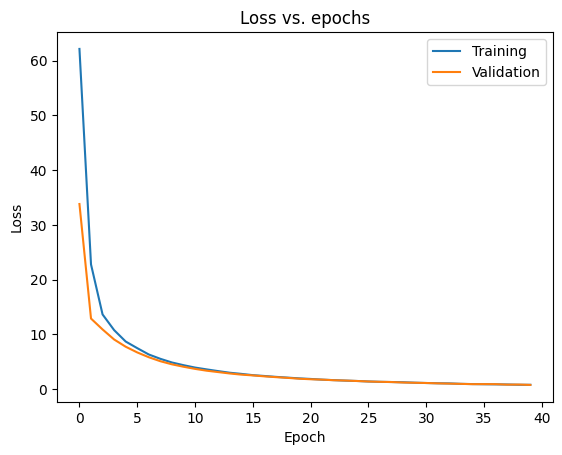

In [63]:
plt.plot(history_LD2.history['loss'])
plt.plot(history_LD2.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [64]:
get_test_accuracy(model_LD2, test_set_x.T, y_test)


accuracy: 0.974


Combination L2 & Dropout - 0.001 Penalty Rate and 0.2 Dropout Rate 

In [65]:
model_LD3 = Sequential([#Flatten(input_shape = (64, 64, 3)),
                     Dense(64, activation='relu',input_shape = (12288,),kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                     Dropout(0.2),
                    Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)), 
                    Dropout(0.2),
                    Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

model_LD3.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history_LD3 = model_LD3.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df_LD3 = pd.DataFrame(history_LD3.history)
df_LD3

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 2s - 349ms/step - binary_accuracy: 0.6082 - loss: 68.1177 - val_binary_accuracy: 0.8816 - val_loss: 9.0624
Epoch 2/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.7558 - loss: 19.3887 - val_binary_accuracy: 0.8816 - val_loss: 8.7240
Epoch 3/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.8874 - loss: 8.7874 - val_binary_accuracy: 0.9167 - val_loss: 6.0630
Epoch 4/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.8260 - loss: 7.1184 - val_binary_accuracy: 0.9342 - val_loss: 5.5028
Epoch 5/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.8816 - loss: 5.5131 - val_binary_accuracy: 0.9386 - val_loss: 5.0404
Epoch 6/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.8904 - loss: 4.9738 - val_binary_accuracy: 0.9298 - val_loss: 4.6421
Epoch 7/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.8918 - loss: 4.5791 - val_binary_accuracy: 0.9386 - val_loss: 4.2769
Epoch 8/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9072 - loss: 4.1981 - val_binary_accuracy: 0.9342 - val_loss: 3.9744
Epoch 9/40
6/6 - 0s - 23ms/step 

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.608187,68.117683,0.881579,9.062382
1,0.755848,19.388733,0.881579,8.724027
2,0.887427,8.787446,0.916667,6.063004
3,0.826023,7.118361,0.934211,5.502759
4,0.881579,5.513076,0.938596,5.040387
5,0.890351,4.973844,0.929825,4.642086
6,0.891813,4.579123,0.938596,4.276861
7,0.907164,4.198088,0.934211,3.974408
8,0.921784,3.904315,0.940789,3.667560
9,0.928363,3.588788,0.942982,3.443723


Combination L2 & Dropout - 0.002 Penalty Rate and 0.2 Dropout Rate for first hidden layer, then 0.001 l2 and 0.15 dropout rate for second hidden layer, output layer with 0.001 l2

In [66]:
model_LD4 = Sequential([#Flatten(input_shape = (64, 64, 3)),
                     Dense(64, activation='relu',input_shape = (12288,),kernel_regularizer=tf.keras.regularizers.l2(0.002)),
                     Dropout(0.2),
                    Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)), 
                    Dropout(0.15),
                    Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

model_LD4.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history_LD4 = model_LD4.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df_LD4 = pd.DataFrame(history_LD4.history)
df_LD4

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 2s - 349ms/step - binary_accuracy: 0.5980 - loss: 155.0935 - val_binary_accuracy: 0.4715 - val_loss: 99.0121
Epoch 2/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.6623 - loss: 36.8401 - val_binary_accuracy: 0.5746 - val_loss: 12.2744
Epoch 3/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.6981 - loss: 12.8046 - val_binary_accuracy: 0.8882 - val_loss: 10.6343
Epoch 4/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.7924 - loss: 11.2218 - val_binary_accuracy: 0.7018 - val_loss: 10.3661
Epoch 5/40
6/6 - 0s - 33ms/step - binary_accuracy: 0.7690 - loss: 10.2074 - val_binary_accuracy: 0.8377 - val_loss: 9.5737
Epoch 6/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.8129 - loss: 9.3344 - val_binary_accuracy: 0.8772 - val_loss: 8.7631
Epoch 7/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.8107 - loss: 8.5908 - val_binary_accuracy: 0.8772 - val_loss: 8.0713
Epoch 8/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.8253 - loss: 7.9044 - val_binary_accuracy: 0.9364 - val_loss: 7.4690
Epoch 9/40
6/6 - 0s - 21

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.597953,155.093460,0.471491,99.012093
1,0.662281,36.840134,0.574561,12.274354
2,0.698099,12.804601,0.888158,10.634262
3,0.792398,11.221802,0.701754,10.366093
4,0.769006,10.207428,0.837719,9.573722
5,0.812865,9.334358,0.877193,8.763104
6,0.810673,8.590835,0.877193,8.071285
7,0.825292,7.904430,0.936404,7.469026
8,0.854532,7.271656,0.945175,6.886240
9,0.870614,6.725547,0.942982,6.371681


Combination L2 & Dropout - 0.001 Penalty Rate and 0.2 Dropout Rate for first hidden layer, then 0.002 l2 and 0.15 dropout rate for second hidden layer, output layer with 0.002 l2

In [67]:
model_LD5 = Sequential([#Flatten(input_shape = (64, 64, 3)),
                     Dense(64, activation='relu',input_shape = (12288,),kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                     Dropout(0.2),
                    Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.002)), 
                    Dropout(0.15),
                    Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.002))
])

model_LD5.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history_LD5 = model_LD5.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df_LD5 = pd.DataFrame(history_LD5.history)
df_LD5

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 2s - 399ms/step - binary_accuracy: 0.5197 - loss: 150.4365 - val_binary_accuracy: 0.5285 - val_loss: 35.9684
Epoch 2/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.5570 - loss: 21.4672 - val_binary_accuracy: 0.7478 - val_loss: 6.9567
Epoch 3/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.7054 - loss: 8.5585 - val_binary_accuracy: 0.8531 - val_loss: 7.3264
Epoch 4/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.7193 - loss: 7.5967 - val_binary_accuracy: 0.5943 - val_loss: 7.4032
Epoch 5/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.6930 - loss: 7.3459 - val_binary_accuracy: 0.8706 - val_loss: 6.9472
Epoch 6/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.7654 - loss: 6.8723 - val_binary_accuracy: 0.9013 - val_loss: 6.4238
Epoch 7/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.7953 - loss: 6.4337 - val_binary_accuracy: 0.9057 - val_loss: 5.9595
Epoch 8/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.7887 - loss: 6.0301 - val_binary_accuracy: 0.9254 - val_loss: 5.5943
Epoch 9/40
6/6 - 0s - 22ms/ste

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.519737,150.436493,0.528509,35.968422
1,0.557018,21.467232,0.747807,6.956728
2,0.705409,8.558504,0.853070,7.326421
3,0.719298,7.596695,0.594298,7.403170
4,0.692982,7.345872,0.870614,6.947236
5,0.765351,6.872253,0.901316,6.423792
6,0.795322,6.433726,0.905702,5.959491
7,0.788743,6.030115,0.925439,5.594294
8,0.824561,5.566766,0.929825,5.190992
9,0.839181,5.208367,0.914474,4.901390


#### BATCH NORMALIZATION

Default Batch Normalization

In [68]:
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
model_bn1 = Sequential([#Flatten(input_shape = (64, 64, 3)),
                     Dense(64, activation='relu',input_shape = (12288,)),
                     BatchNormalization(momentum=0.99, # default is 0.99
                                    epsilon=0.001, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer='zeros', # default is beta_initializer='zeros'
                                    gamma_initializer='ones'), # default is gamma_initializer='ones'),
                    Dense(48, activation='relu'),
                    BatchNormalization(momentum=0.99, # default is 0.99
                                    epsilon=0.001, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer='zeros', # default is beta_initializer='zeros'
                                    gamma_initializer='ones'), # default is gamma_initializer='ones'),
                    Dense(1, activation='sigmoid')

])

model_bn1.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history_bn1 = model_bn1.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df_bn1 = pd.DataFrame(history_bn1.history)
df_bn1

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 3s - 442ms/step - binary_accuracy: 0.8238 - loss: 0.3508 - val_binary_accuracy: 0.7018 - val_loss: 4.1833
Epoch 2/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9627 - loss: 0.1269 - val_binary_accuracy: 0.7018 - val_loss: 2.6264
Epoch 3/40
6/6 - 0s - 20ms/step - binary_accuracy: 0.9605 - loss: 0.1091 - val_binary_accuracy: 0.7763 - val_loss: 0.9038
Epoch 4/40
6/6 - 0s - 20ms/step - binary_accuracy: 0.9627 - loss: 0.1063 - val_binary_accuracy: 0.8816 - val_loss: 0.4452
Epoch 5/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9693 - loss: 0.0910 - val_binary_accuracy: 0.8596 - val_loss: 0.4956
Epoch 6/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9671 - loss: 0.0935 - val_binary_accuracy: 0.8969 - val_loss: 0.3262
Epoch 7/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9759 - loss: 0.0770 - val_binary_accuracy: 0.9101 - val_loss: 0.2557
Epoch 8/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9773 - loss: 0.0739 - val_binary_accuracy: 0.9211 - val_loss: 0.2364
Epoch 9/40
6/6 - 0s - 21ms/step - 

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.823830,0.350822,0.701754,4.183346
1,0.962719,0.126942,0.701754,2.626352
2,0.960526,0.109118,0.776316,0.903778
3,0.962719,0.106328,0.881579,0.445248
4,0.969298,0.090961,0.859649,0.495590
5,0.967105,0.093471,0.896930,0.326196
6,0.975877,0.077006,0.910088,0.255730
7,0.977339,0.073893,0.921053,0.236364
8,0.980263,0.067415,0.918860,0.241914
9,0.980994,0.063281,0.929825,0.217647


In [69]:
model_bn2 = Sequential([
                    Dense(64, activation = 'relu', input_shape = (12288,)),
                    BatchNormalization(momentum=0.90, # default is 0.99
                                    epsilon=0.001, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer='zeros', # default is beta_initializer='zeros'
                                    gamma_initializer='ones'), # default is gamma_initializer='ones'),
                    Dense(48, activation='relu'),
                    BatchNormalization(momentum=0.90, # default is 0.99
                                    epsilon=0.001, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer='zeros', # default is beta_initializer='zeros'
                                    gamma_initializer='ones'), # default is gamma_initializer='ones'),
                    Dense(1, activation = 'sigmoid')
])

model_bn2.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history_bn2 = model_bn2.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df_bn2 = pd.DataFrame(history_bn2.history)
df_bn2

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 3s - 440ms/step - binary_accuracy: 0.7785 - loss: 0.4460 - val_binary_accuracy: 0.5943 - val_loss: 2.1472
Epoch 2/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9496 - loss: 0.1481 - val_binary_accuracy: 0.8399 - val_loss: 0.4159
Epoch 3/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9576 - loss: 0.1185 - val_binary_accuracy: 0.9452 - val_loss: 0.1692
Epoch 4/40
6/6 - 0s - 20ms/step - binary_accuracy: 0.9730 - loss: 0.0967 - val_binary_accuracy: 0.9496 - val_loss: 0.1294
Epoch 5/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9722 - loss: 0.0866 - val_binary_accuracy: 0.9518 - val_loss: 0.1189
Epoch 6/40
6/6 - 0s - 32ms/step - binary_accuracy: 0.9766 - loss: 0.0713 - val_binary_accuracy: 0.9539 - val_loss: 0.1187
Epoch 7/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9773 - loss: 0.0639 - val_binary_accuracy: 0.9583 - val_loss: 0.0988
Epoch 8/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9817 - loss: 0.0603 - val_binary_accuracy: 0.9627 - val_loss: 0.0882
Epoch 9/40
6/6 - 0s - 21ms/step - 

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.778509,0.446019,0.594298,2.147167
1,0.949561,0.148066,0.839912,0.415932
2,0.957602,0.118495,0.945175,0.169224
3,0.972953,0.096691,0.949561,0.129439
4,0.972222,0.086569,0.951754,0.118949
5,0.976608,0.071267,0.953947,0.118745
6,0.977339,0.063922,0.958333,0.098784
7,0.981725,0.060306,0.962719,0.088247
8,0.980263,0.051763,0.962719,0.088324
9,0.984649,0.051509,0.971491,0.080095


In [70]:
model_bn3 = Sequential([
                    Dense(64, activation = 'relu', input_shape = (12288,)),
                    BatchNormalization(momentum=0.90, # default is 0.99
                                    epsilon=0.005, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer='zeros', # default is beta_initializer='zeros'
                                    gamma_initializer='ones'), # default is gamma_initializer='ones'),
                    Dense(48, activation='relu'),
                    BatchNormalization(momentum=0.90, # default is 0.99
                                    epsilon=0.005, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer='zeros', # default is beta_initializer='zeros'
                                    gamma_initializer='ones'), # default is gamma_initializer='ones'),
                    Dense(1, activation = 'sigmoid')
])

model_bn3.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history_bn3 = model_bn3.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df_bn3 = pd.DataFrame(history_bn3.history)
df_bn3

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 3s - 457ms/step - binary_accuracy: 0.8692 - loss: 0.2968 - val_binary_accuracy: 0.8772 - val_loss: 0.6257
Epoch 2/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9510 - loss: 0.1177 - val_binary_accuracy: 0.9386 - val_loss: 0.2446
Epoch 3/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9664 - loss: 0.0883 - val_binary_accuracy: 0.9496 - val_loss: 0.1755
Epoch 4/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9781 - loss: 0.0675 - val_binary_accuracy: 0.9583 - val_loss: 0.1436
Epoch 5/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.9795 - loss: 0.0570 - val_binary_accuracy: 0.9561 - val_loss: 0.1305
Epoch 6/40
6/6 - 0s - 34ms/step - binary_accuracy: 0.9817 - loss: 0.0525 - val_binary_accuracy: 0.9605 - val_loss: 0.1175
Epoch 7/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9825 - loss: 0.0465 - val_binary_accuracy: 0.9649 - val_loss: 0.1062
Epoch 8/40
6/6 - 0s - 24ms/step - binary_accuracy: 0.9861 - loss: 0.0450 - val_binary_accuracy: 0.9649 - val_loss: 0.0977
Epoch 9/40
6/6 - 0s - 22ms/step - 

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.869152,0.296813,0.877193,0.625681
1,0.951023,0.117672,0.938596,0.244559
2,0.966374,0.088269,0.949561,0.175464
3,0.978070,0.067453,0.958333,0.143577
4,0.979532,0.057014,0.956140,0.130549
5,0.981725,0.052462,0.960526,0.117519
6,0.982456,0.046510,0.964912,0.106174
7,0.986111,0.044970,0.964912,0.097682
8,0.986842,0.042216,0.969298,0.100199
9,0.983918,0.060900,0.969298,0.140001


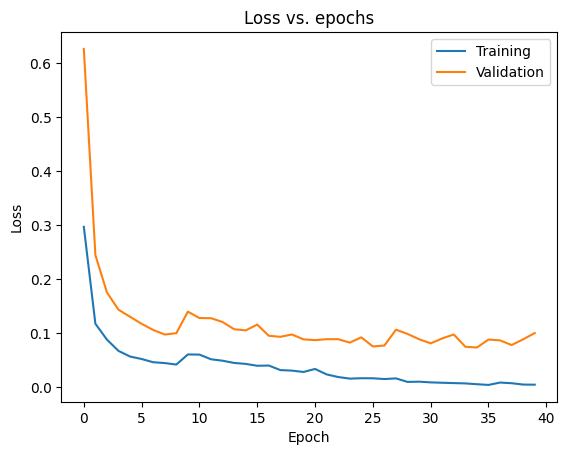

In [71]:
plt.plot(history_bn3.history['loss'])
plt.plot(history_bn3.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [72]:
model_bn4 = Sequential([
                    Dense(64, activation = 'relu', input_shape = (12288,)),
                    BatchNormalization(momentum=0.90, # default is 0.99
                                    epsilon=0.007, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer='zeros', # default is beta_initializer='zeros'
                                    gamma_initializer='ones'), # default is gamma_initializer='ones'),
                    Dense(48, activation='relu'),
                    BatchNormalization(momentum=0.90, # default is 0.99
                                    epsilon=0.007, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer='zeros', # default is beta_initializer='zeros'
                                    gamma_initializer='ones'), # default is gamma_initializer='ones'),
                    Dense(1, activation = 'sigmoid')
])

model_bn4.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history_bn4 = model_bn4.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df_bn4 = pd.DataFrame(history_bn4.history)
df_bn4

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 3s - 478ms/step - binary_accuracy: 0.8268 - loss: 0.3663 - val_binary_accuracy: 0.7851 - val_loss: 1.4798
Epoch 2/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9430 - loss: 0.1520 - val_binary_accuracy: 0.9276 - val_loss: 0.2723
Epoch 3/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9554 - loss: 0.1202 - val_binary_accuracy: 0.9364 - val_loss: 0.1843
Epoch 4/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9561 - loss: 0.1145 - val_binary_accuracy: 0.9518 - val_loss: 0.1966
Epoch 5/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9671 - loss: 0.1010 - val_binary_accuracy: 0.9518 - val_loss: 0.1860
Epoch 6/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9627 - loss: 0.1020 - val_binary_accuracy: 0.9430 - val_loss: 0.1710
Epoch 7/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9708 - loss: 0.0842 - val_binary_accuracy: 0.9539 - val_loss: 0.1573
Epoch 8/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9693 - loss: 0.0841 - val_binary_accuracy: 0.9518 - val_loss: 0.1526
Epoch 9/40
6/6 - 0s - 21ms/step - 

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.826754,0.366343,0.785088,1.479760
1,0.942982,0.151981,0.927632,0.272334
2,0.955409,0.120235,0.936404,0.184289
3,0.956140,0.114516,0.951754,0.196606
4,0.967105,0.101042,0.951754,0.185973
5,0.962719,0.102033,0.942982,0.171028
6,0.970760,0.084217,0.953947,0.157345
7,0.969298,0.084092,0.951754,0.152600
8,0.972222,0.073252,0.953947,0.147268
9,0.974415,0.074607,0.956140,0.137510


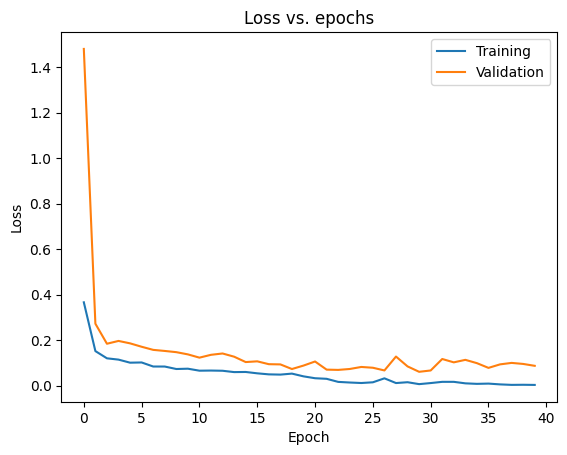

In [73]:
plt.plot(history_bn4.history['loss'])
plt.plot(history_bn4.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [74]:
model_bn5 = Sequential([
                    Dense(64, activation = 'relu', input_shape = (12288,)),
                    BatchNormalization(momentum=0.90, # default is 0.99
                                    epsilon=0.006, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1), # default is beta_initializer='zeros'
                                    gamma_initializer=tf.keras.initializers.Constant(value=0.7)), # default is gamma_initializer='ones'),
                    Dense(48, activation='relu'),
                    BatchNormalization(momentum=0.90, # default is 0.99
                                    epsilon=0.006, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1), # default is beta_initializer='zeros'
                                    gamma_initializer=tf.keras.initializers.Constant(value=0.7)), # default is gamma_initializer='ones'),
                    Dense(1, activation = 'sigmoid')
])

model_bn5.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history_bn5 = model_bn5.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df_bn5 = pd.DataFrame(history_bn5.history)
df_bn5

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 3s - 453ms/step - binary_accuracy: 0.7573 - loss: 0.4951 - val_binary_accuracy: 0.7522 - val_loss: 1.0057
Epoch 2/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9364 - loss: 0.1942 - val_binary_accuracy: 0.8048 - val_loss: 0.4612
Epoch 3/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9459 - loss: 0.1464 - val_binary_accuracy: 0.9474 - val_loss: 0.1551
Epoch 4/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9539 - loss: 0.1091 - val_binary_accuracy: 0.9496 - val_loss: 0.1186
Epoch 5/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9642 - loss: 0.0983 - val_binary_accuracy: 0.9583 - val_loss: 0.1019
Epoch 6/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9693 - loss: 0.0808 - val_binary_accuracy: 0.9605 - val_loss: 0.0861
Epoch 7/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9751 - loss: 0.0670 - val_binary_accuracy: 0.9627 - val_loss: 0.0811
Epoch 8/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9751 - loss: 0.0657 - val_binary_accuracy: 0.9759 - val_loss: 0.0685
Epoch 9/40
6/6 - 0s - 21ms/step - 

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.757310,0.495060,0.752193,1.005691
1,0.936404,0.194178,0.804825,0.461198
2,0.945906,0.146395,0.947368,0.155145
3,0.953947,0.109138,0.949561,0.118573
4,0.964181,0.098318,0.958333,0.101912
5,0.969298,0.080802,0.960526,0.086087
6,0.975146,0.067035,0.962719,0.081095
7,0.975146,0.065688,0.975877,0.068457
8,0.978801,0.061780,0.978070,0.067572
9,0.984649,0.053745,0.973684,0.071134


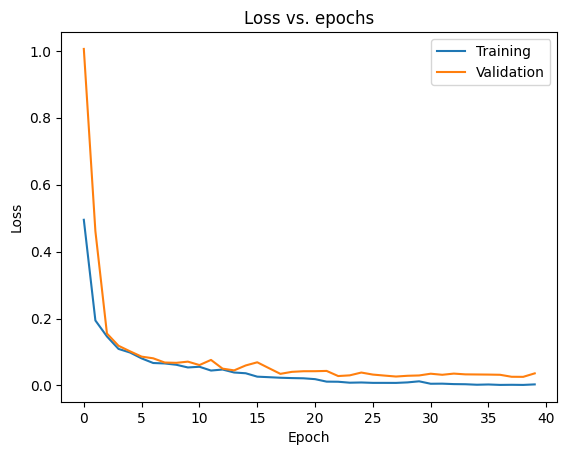

In [75]:
plt.plot(history_bn5.history['loss'])
plt.plot(history_bn5.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [76]:
get_test_accuracy(model_bn5, test_set_x.T, y_test)


accuracy: 0.991


### Combination of batch normalization and drop out 0.2 and 0.2

In [77]:
model_bd1 = Sequential([
                    Dense(64, activation = 'relu', input_shape = (12288,)),
                    BatchNormalization(momentum=0.90, # default is 0.99
                                    epsilon=0.006, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1), # default is beta_initializer='zeros'
                                    gamma_initializer=tf.keras.initializers.Constant(value=0.7)), # default is gamma_initializer='ones'),
                    Dropout(0.2),
                    Dense(48, activation='relu'),
                    BatchNormalization(momentum=0.90, # default is 0.99
                                    epsilon=0.006, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1), # default is beta_initializer='zeros'
                                    gamma_initializer=tf.keras.initializers.Constant(value=0.7)), # default is gamma_initializer='ones'),
                    Dropout(0.2),
                    Dense(1, activation = 'sigmoid')
])

model_bd1.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history_bd1 = model_bd1.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df_bd1 = pd.DataFrame(history_bd1.history)
df_bd1

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 3s - 503ms/step - binary_accuracy: 0.7449 - loss: 0.5088 - val_binary_accuracy: 0.5439 - val_loss: 3.9797
Epoch 2/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.9240 - loss: 0.2160 - val_binary_accuracy: 0.7478 - val_loss: 0.8486
Epoch 3/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9481 - loss: 0.1554 - val_binary_accuracy: 0.9342 - val_loss: 0.2110
Epoch 4/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.9627 - loss: 0.1181 - val_binary_accuracy: 0.9518 - val_loss: 0.1521
Epoch 5/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.9671 - loss: 0.1068 - val_binary_accuracy: 0.9518 - val_loss: 0.1201
Epoch 6/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.9686 - loss: 0.0928 - val_binary_accuracy: 0.9627 - val_loss: 0.1118
Epoch 7/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9751 - loss: 0.0797 - val_binary_accuracy: 0.9627 - val_loss: 0.1223
Epoch 8/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9825 - loss: 0.0674 - val_binary_accuracy: 0.9671 - val_loss: 0.0994
Epoch 9/40
6/6 - 0s - 22ms/step - 

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.744883,0.508826,0.543860,3.979748
1,0.923977,0.215982,0.747807,0.848588
2,0.948099,0.155358,0.934211,0.211011
3,0.962719,0.118139,0.951754,0.152139
4,0.967105,0.106760,0.951754,0.120075
5,0.968567,0.092808,0.962719,0.111828
6,0.975146,0.079739,0.962719,0.122320
7,0.982456,0.067368,0.967105,0.099394
8,0.986111,0.054602,0.967105,0.093971
9,0.983918,0.051682,0.969298,0.085601


### Combination of batch normalization and drop out 0.3 and 0.2

In [78]:
model_bd2 = Sequential([
                    Dense(64, activation = 'relu', input_shape = (12288,)),
                    BatchNormalization(momentum=0.90, # default is 0.99
                                    epsilon=0.005, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1), # default is beta_initializer='zeros'
                                    gamma_initializer=tf.keras.initializers.Constant(value=0.9)), # default is gamma_initializer='ones'),
                    Dropout(0.3),
                    Dense(48, activation='relu'),
                    BatchNormalization(momentum=0.90, # default is 0.99
                                    epsilon=0.005, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1), # default is beta_initializer='zeros'
                                    gamma_initializer=tf.keras.initializers.Constant(value=0.9)), # default is gamma_initializer='ones'),
                    Dropout(0.2),
                    Dense(1, activation = 'sigmoid')
])

model_bd2.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history_bd2 = model_bd2.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df_bd2 = pd.DataFrame(history_bd2.history)
df_bd2

c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
6/6 - 3s - 471ms/step - binary_accuracy: 0.8070 - loss: 0.4281 - val_binary_accuracy: 0.7390 - val_loss: 1.3094
Epoch 2/40
6/6 - 0s - 34ms/step - binary_accuracy: 0.9262 - loss: 0.1977 - val_binary_accuracy: 0.9057 - val_loss: 0.2969
Epoch 3/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9364 - loss: 0.1779 - val_binary_accuracy: 0.9452 - val_loss: 0.2109
Epoch 4/40
6/6 - 0s - 25ms/step - binary_accuracy: 0.9474 - loss: 0.1429 - val_binary_accuracy: 0.9452 - val_loss: 0.1570
Epoch 5/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9525 - loss: 0.1253 - val_binary_accuracy: 0.9496 - val_loss: 0.1422
Epoch 6/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9591 - loss: 0.1110 - val_binary_accuracy: 0.9452 - val_loss: 0.1457
Epoch 7/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9635 - loss: 0.1029 - val_binary_accuracy: 0.9496 - val_loss: 0.1471
Epoch 8/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9627 - loss: 0.1027 - val_binary_accuracy: 0.9518 - val_loss: 0.1312
Epoch 9/40
6/6 - 0s - 2

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.807018,0.428117,0.739035,1.309376
1,0.926170,0.197718,0.905702,0.296944
2,0.936404,0.177880,0.945175,0.210896
3,0.947368,0.142863,0.945175,0.156982
4,0.952485,0.125261,0.949561,0.142192
5,0.959064,0.111033,0.945175,0.145738
6,0.963450,0.102918,0.949561,0.147124
7,0.962719,0.102653,0.951754,0.131160
8,0.971491,0.100392,0.962719,0.127984
9,0.972953,0.085471,0.962719,0.124653


### Combination of batch normalization and drop out 0.2 and 0.1

In [79]:
model_bd3 = Sequential([
                    Dense(64, activation = 'relu', input_shape = (12288,)),
                    BatchNormalization(momentum=0.95, # default is 0.99
                                    epsilon=0.005, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1), # default is beta_initializer='zeros'
                                    gamma_initializer=tf.keras.initializers.Constant(value=0.8)), # default is gamma_initializer='ones'),
                    Dropout(0.2),
                    Dense(48, activation='relu'),
                    BatchNormalization(momentum=0.90, # default is 0.99
                                    epsilon=0.005, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1), # default is beta_initializer='zeros'
                                    gamma_initializer=tf.keras.initializers.Constant(value=0.8)), # default is gamma_initializer='ones'),
                    Dropout(0.1),
                    Dense(1, activation = 'sigmoid')
])

model_bd3.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history_bd3 = model_bd3.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df_bd3 = pd.DataFrame(history_bd3.history)
df_bd3

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 3s - 547ms/step - binary_accuracy: 0.7156 - loss: 0.5768 - val_binary_accuracy: 0.6404 - val_loss: 1.7494
Epoch 2/40
6/6 - 0s - 24ms/step - binary_accuracy: 0.9306 - loss: 0.1988 - val_binary_accuracy: 0.9320 - val_loss: 0.2689
Epoch 3/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.9401 - loss: 0.1761 - val_binary_accuracy: 0.9320 - val_loss: 0.2026
Epoch 4/40
6/6 - 0s - 24ms/step - binary_accuracy: 0.9320 - loss: 0.1676 - val_binary_accuracy: 0.9408 - val_loss: 0.2012
Epoch 5/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9510 - loss: 0.1462 - val_binary_accuracy: 0.9408 - val_loss: 0.1761
Epoch 6/40
6/6 - 0s - 25ms/step - binary_accuracy: 0.9488 - loss: 0.1388 - val_binary_accuracy: 0.9408 - val_loss: 0.1684
Epoch 7/40
6/6 - 0s - 27ms/step - binary_accuracy: 0.9627 - loss: 0.1094 - val_binary_accuracy: 0.9496 - val_loss: 0.1363
Epoch 8/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.9664 - loss: 0.1038 - val_binary_accuracy: 0.9561 - val_loss: 0.1311
Epoch 9/40
6/6 - 0s - 33ms/step - 

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.715643,0.576780,0.640351,1.749407
1,0.930556,0.198788,0.932018,0.268916
2,0.940058,0.176102,0.932018,0.202559
3,0.932018,0.167640,0.940789,0.201215
4,0.951023,0.146244,0.940789,0.176126
5,0.948830,0.138766,0.940789,0.168406
6,0.962719,0.109397,0.949561,0.136323
7,0.966374,0.103809,0.956140,0.131091
8,0.969298,0.101582,0.964912,0.130983
9,0.966374,0.091350,0.947368,0.142498


In [80]:
get_test_accuracy(model_bd3, test_set_x.T, y_test)


accuracy: 0.989


### Combination of batch normalization and drop out 0.1 and 0.1

In [81]:
model_bd4 = Sequential([
                    Dense(64, activation = 'relu', input_shape = (12288,)),
                    BatchNormalization(momentum=0.99, # default is 0.99
                                    epsilon=0.007, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1), # default is beta_initializer='zeros'
                                    gamma_initializer=tf.keras.initializers.Constant(value=0.8)), # default is gamma_initializer='ones'),
                    Dropout(0.1),
                    Dense(48, activation='relu'),
                    BatchNormalization(momentum=0.99, # default is 0.99
                                    epsilon=0.007, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1), # default is beta_initializer='zeros'
                                    gamma_initializer=tf.keras.initializers.Constant(value=0.7)), # default is gamma_initializer='ones'),
                    Dropout(0.1),
                    Dense(1, activation = 'sigmoid')
])

model_bd4.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history_bd4 = model_bd4.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df_bd4 = pd.DataFrame(history_bd4.history)
df_bd4

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 3s - 487ms/step - binary_accuracy: 0.7961 - loss: 0.4103 - val_binary_accuracy: 0.5439 - val_loss: 10.9879
Epoch 2/40
6/6 - 0s - 24ms/step - binary_accuracy: 0.9152 - loss: 0.2216 - val_binary_accuracy: 0.5702 - val_loss: 7.6136
Epoch 3/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.9225 - loss: 0.1993 - val_binary_accuracy: 0.5789 - val_loss: 5.1122
Epoch 4/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9291 - loss: 0.1846 - val_binary_accuracy: 0.6250 - val_loss: 2.9411
Epoch 5/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9408 - loss: 0.1642 - val_binary_accuracy: 0.6645 - val_loss: 2.0422
Epoch 6/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9459 - loss: 0.1584 - val_binary_accuracy: 0.7171 - val_loss: 1.4391
Epoch 7/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9539 - loss: 0.1362 - val_binary_accuracy: 0.7346 - val_loss: 1.2346
Epoch 8/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9561 - loss: 0.1383 - val_binary_accuracy: 0.7697 - val_loss: 0.8982
Epoch 9/40
6/6 - 0s - 34ms/step -

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.796053,0.410282,0.543860,10.987932
1,0.915205,0.221627,0.570175,7.613576
2,0.922515,0.199318,0.578947,5.112213
3,0.929094,0.184564,0.625000,2.941089
4,0.940789,0.164193,0.664474,2.042243
5,0.945906,0.158363,0.717105,1.439105
6,0.953947,0.136153,0.734649,1.234576
7,0.956140,0.138262,0.769737,0.898152
8,0.961988,0.120561,0.857456,0.542856
9,0.954678,0.129386,0.907895,0.338225


### Combination of batch normalization and drop out 0.1 and 0.01

In [82]:
model_bd5 = Sequential([
                    Dense(64, activation = 'relu', input_shape = (12288,)),
                    BatchNormalization(momentum=0.90, # default is 0.99
                                    epsilon=0.005, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1), # default is beta_initializer='zeros'
                                    gamma_initializer=tf.keras.initializers.Constant(value=0.7)), # default is gamma_initializer='ones'),
                    Dropout(0.1),
                    Dense(48, activation='relu'),
                    BatchNormalization(momentum=0.90, # default is 0.99
                                    epsilon=0.005, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1), # default is beta_initializer='zeros'
                                    gamma_initializer=tf.keras.initializers.Constant(value=0.7)), # default is gamma_initializer='ones'),
                    Dropout(0.01),
                    Dense(1, activation = 'sigmoid')
])

model_bd5.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history_bd5 = model_bd5.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df_bd5 = pd.DataFrame(history_bd5.history)
df_bd5

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 3s - 488ms/step - binary_accuracy: 0.7873 - loss: 0.4386 - val_binary_accuracy: 0.6557 - val_loss: 2.0613
Epoch 2/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9203 - loss: 0.1886 - val_binary_accuracy: 0.8136 - val_loss: 0.6514
Epoch 3/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9357 - loss: 0.1491 - val_binary_accuracy: 0.9123 - val_loss: 0.2321
Epoch 4/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9539 - loss: 0.1284 - val_binary_accuracy: 0.9474 - val_loss: 0.1525
Epoch 5/40
6/6 - 0s - 21ms/step - binary_accuracy: 0.9613 - loss: 0.1152 - val_binary_accuracy: 0.9518 - val_loss: 0.1392
Epoch 6/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9635 - loss: 0.1009 - val_binary_accuracy: 0.9496 - val_loss: 0.1370
Epoch 7/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9620 - loss: 0.0934 - val_binary_accuracy: 0.9474 - val_loss: 0.1391
Epoch 8/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9751 - loss: 0.0852 - val_binary_accuracy: 0.9518 - val_loss: 0.1558
Epoch 9/40
6/6 - 0s - 21ms/step - 

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.787281,0.438590,0.655702,2.061286
1,0.920322,0.188598,0.813596,0.651409
2,0.935673,0.149111,0.912281,0.232140
3,0.953947,0.128411,0.947368,0.152538
4,0.961257,0.115211,0.951754,0.139195
5,0.963450,0.100852,0.949561,0.137005
6,0.961988,0.093377,0.947368,0.139150
7,0.975146,0.085224,0.951754,0.155840
8,0.973684,0.073976,0.951754,0.160125
9,0.976608,0.081610,0.962719,0.146721


### Mixture of batch normalization, dropout, and L2

In [83]:
model_bdl1 = Sequential([
                    Dense(64, activation = 'relu', input_shape = (12288,), kernel_regularizer=tf.keras.regularizers.l2(0.002)),
                    BatchNormalization(momentum=0.90, # default is 0.99
                                    epsilon=0.005, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1), # default is beta_initializer='zeros'
                                    gamma_initializer=tf.keras.initializers.Constant(value=0.9)), # default is gamma_initializer='ones'),
                    Dropout(0.3),
                    Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.002)),
                    BatchNormalization(momentum=0.90, # default is 0.99
                                    epsilon=0.005, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1), # default is beta_initializer='zeros'
                                    gamma_initializer=tf.keras.initializers.Constant(value=0.9)), # default is gamma_initializer='ones'),
                    Dropout(0.2),
                    Dense(1, activation = 'sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.002))
])

model_bdl1.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history_bdl1 = model_bdl1.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df_bdl1 = pd.DataFrame(history_bd1.history)
df_bdl1

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 3s - 517ms/step - binary_accuracy: 0.7646 - loss: 8.5578 - val_binary_accuracy: 0.6206 - val_loss: 18.4723
Epoch 2/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9028 - loss: 17.1355 - val_binary_accuracy: 0.8399 - val_loss: 17.5993
Epoch 3/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9254 - loss: 16.8142 - val_binary_accuracy: 0.9254 - val_loss: 15.5864
Epoch 4/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9364 - loss: 14.7545 - val_binary_accuracy: 0.9408 - val_loss: 13.3373
Epoch 5/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9401 - loss: 12.5499 - val_binary_accuracy: 0.9408 - val_loss: 11.3031
Epoch 6/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.9488 - loss: 10.5930 - val_binary_accuracy: 0.9518 - val_loss: 9.5427
Epoch 7/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9532 - loss: 8.9917 - val_binary_accuracy: 0.9232 - val_loss: 8.2311
Epoch 8/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9598 - loss: 7.6704 - val_binary_accuracy: 0.9496 - val_loss: 7.0008
Epoch 9/40
6/6 - 0s - 22

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.744883,0.508826,0.543860,3.979748
1,0.923977,0.215982,0.747807,0.848588
2,0.948099,0.155358,0.934211,0.211011
3,0.962719,0.118139,0.951754,0.152139
4,0.967105,0.106760,0.951754,0.120075
5,0.968567,0.092808,0.962719,0.111828
6,0.975146,0.079739,0.962719,0.122320
7,0.982456,0.067368,0.967105,0.099394
8,0.986111,0.054602,0.967105,0.093971
9,0.983918,0.051682,0.969298,0.085601


### Mixture of batch normalization, dropout, and L2 0.001 penalty rate

In [84]:
model_bdl2 = Sequential([
                    Dense(64, activation = 'relu', input_shape = (12288,), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    BatchNormalization(momentum=0.95, # default is 0.99
                                    epsilon=0.005, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1), # default is beta_initializer='zeros'
                                    gamma_initializer=tf.keras.initializers.Constant(value=0.9)), # default is gamma_initializer='ones'),
                    Dropout(0.2),
                    Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    BatchNormalization(momentum=0.95, # default is 0.99
                                    epsilon=0.005, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1), # default is beta_initializer='zeros'
                                    gamma_initializer=tf.keras.initializers.Constant(value=0.9)), # default is gamma_initializer='ones'),
                    Dropout(0.2),
                    Dense(1, activation = 'sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

model_bdl2.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history_bdl2 = model_bdl2.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df_bdl2 = pd.DataFrame(history_bd2.history)
df_bdl2

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 3s - 520ms/step - binary_accuracy: 0.7982 - loss: 4.6964 - val_binary_accuracy: 0.5592 - val_loss: 14.9867
Epoch 2/40
6/6 - 0s - 33ms/step - binary_accuracy: 0.9152 - loss: 9.8721 - val_binary_accuracy: 0.7675 - val_loss: 11.2579
Epoch 3/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9349 - loss: 10.3013 - val_binary_accuracy: 0.9211 - val_loss: 10.0025
Epoch 4/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.9466 - loss: 9.5379 - val_binary_accuracy: 0.9496 - val_loss: 8.9263
Epoch 5/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.9598 - loss: 8.4982 - val_binary_accuracy: 0.9627 - val_loss: 7.8747
Epoch 6/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9620 - loss: 7.5125 - val_binary_accuracy: 0.9561 - val_loss: 6.9581
Epoch 7/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.9642 - loss: 6.6247 - val_binary_accuracy: 0.9539 - val_loss: 6.1764
Epoch 8/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9693 - loss: 5.8572 - val_binary_accuracy: 0.9518 - val_loss: 5.4727
Epoch 9/40
6/6 - 0s - 24ms/ste

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.807018,0.428117,0.739035,1.309376
1,0.926170,0.197718,0.905702,0.296944
2,0.936404,0.177880,0.945175,0.210896
3,0.947368,0.142863,0.945175,0.156982
4,0.952485,0.125261,0.949561,0.142192
5,0.959064,0.111033,0.945175,0.145738
6,0.963450,0.102918,0.949561,0.147124
7,0.962719,0.102653,0.951754,0.131160
8,0.971491,0.100392,0.962719,0.127984
9,0.972953,0.085471,0.962719,0.124653


In [85]:
get_test_accuracy(model_bdl2, test_set_x.T, y_test)


accuracy: 0.575


### Mixture of batch normalization, dropout, and L2 0.003 penalty rate

In [86]:
model_bdl3 = Sequential([
                    Dense(64, activation = 'relu', input_shape = (12288,), kernel_regularizer=tf.keras.regularizers.l2(0.003)),
                    BatchNormalization(momentum=0.85, # default is 0.99
                                    epsilon=0.005, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1), # default is beta_initializer='zeros'
                                    gamma_initializer=tf.keras.initializers.Constant(value=0.9)), # default is gamma_initializer='ones'),
                    Dropout(0.2),
                    Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.003)),
                    BatchNormalization(momentum=0.85, # default is 0.99
                                    epsilon=0.005, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1), # default is beta_initializer='zeros'
                                    gamma_initializer=tf.keras.initializers.Constant(value=0.9)), # default is gamma_initializer='ones'),
                    Dropout(0.2),
                    Dense(1, activation = 'sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.003))
])

model_bdl3.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history_bdl3 = model_bdl3.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df_bdl3 = pd.DataFrame(history_bdl3.history)
df_bdl3

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 3s - 524ms/step - binary_accuracy: 0.8004 - loss: 11.9977 - val_binary_accuracy: 0.7851 - val_loss: 23.0375
Epoch 2/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.9284 - loss: 23.4032 - val_binary_accuracy: 0.9386 - val_loss: 23.3410
Epoch 3/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9364 - loss: 22.3794 - val_binary_accuracy: 0.9452 - val_loss: 20.4650
Epoch 4/40
6/6 - 0s - 25ms/step - binary_accuracy: 0.9510 - loss: 19.2766 - val_binary_accuracy: 0.9057 - val_loss: 17.3751
Epoch 5/40
6/6 - 0s - 25ms/step - binary_accuracy: 0.9569 - loss: 16.2064 - val_binary_accuracy: 0.7961 - val_loss: 14.8031
Epoch 6/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9561 - loss: 13.6021 - val_binary_accuracy: 0.9123 - val_loss: 12.2742
Epoch 7/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.9635 - loss: 11.4342 - val_binary_accuracy: 0.9539 - val_loss: 10.3103
Epoch 8/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.9664 - loss: 9.6931 - val_binary_accuracy: 0.9627 - val_loss: 8.8111
Epoch 9/40
6/6 - 0s 

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.800439,11.997660,0.785088,23.037493
1,0.928363,23.403175,0.938596,23.341022
2,0.936404,22.379353,0.945175,20.464977
3,0.951023,19.276562,0.905702,17.375126
4,0.956871,16.206404,0.796053,14.803060
5,0.956140,13.602071,0.912281,12.274210
6,0.963450,11.434214,0.953947,10.310267
7,0.966374,9.693075,0.962719,8.811103
8,0.962719,8.342480,0.618421,8.672556
9,0.964912,7.259260,0.912281,6.818630


### Mixture of batch normalization, dropout, and L2 0.004 penalty rate

In [87]:
model_bdl4 = Sequential([
                    Dense(64, activation = 'relu', input_shape = (12288,), kernel_regularizer=tf.keras.regularizers.l2(0.004)),
                    BatchNormalization(momentum=0.99, # default is 0.99
                                    epsilon=0.002, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1), # default is beta_initializer='zeros'
                                    gamma_initializer=tf.keras.initializers.Constant(value=0.9)), # default is gamma_initializer='ones'),
                    Dropout(0.2),
                    Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.004)),
                    BatchNormalization(momentum=0.99, # default is 0.99
                                    epsilon=0.002, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1), # default is beta_initializer='zeros'
                                    gamma_initializer=tf.keras.initializers.Constant(value=0.9)), # default is gamma_initializer='ones'),
                    Dropout(0.2),
                    Dense(1, activation = 'sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.004))
])

model_bdl4.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history_bdl4 = model_bdl4.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df_bdl4 = pd.DataFrame(history_bdl4.history)
df_bdl4

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 3s - 520ms/step - binary_accuracy: 0.7624 - loss: 15.3460 - val_binary_accuracy: 0.6118 - val_loss: 36.7722
Epoch 2/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.9006 - loss: 27.4209 - val_binary_accuracy: 0.6053 - val_loss: 31.2299
Epoch 3/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9159 - loss: 23.7711 - val_binary_accuracy: 0.6820 - val_loss: 22.6883
Epoch 4/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.9510 - loss: 18.6368 - val_binary_accuracy: 0.7303 - val_loss: 17.0079
Epoch 5/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.9613 - loss: 14.3543 - val_binary_accuracy: 0.5943 - val_loss: 14.2300
Epoch 6/40
6/6 - 0s - 24ms/step - binary_accuracy: 0.9613 - loss: 11.1019 - val_binary_accuracy: 0.7610 - val_loss: 9.8828
Epoch 7/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9583 - loss: 8.6939 - val_binary_accuracy: 0.9474 - val_loss: 7.5065
Epoch 8/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9678 - loss: 6.8830 - val_binary_accuracy: 0.9561 - val_loss: 6.0120
Epoch 9/40
6/6 - 0s - 2

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.762427,15.345957,0.611842,36.772247
1,0.900585,27.420950,0.605263,31.229904
2,0.915936,23.771082,0.682018,22.688292
3,0.951023,18.636759,0.730263,17.007868
4,0.961257,14.354318,0.594298,14.229979
5,0.961257,11.101918,0.760965,9.882815
6,0.958333,8.693851,0.947368,7.506510
7,0.967836,6.882955,0.956140,6.012006
8,0.961988,5.551365,0.947368,4.916865
9,0.963450,4.540086,0.927632,4.085406


### Mixture of batch normalization, dropout, and L2 mixture of changes

In [88]:
model_bdl5 = Sequential([
                    Dense(64, activation = 'relu', input_shape = (12288,), kernel_regularizer=tf.keras.regularizers.l2(0.002)),
                    BatchNormalization(momentum=0.90, # default is 0.99
                                    epsilon=0.005, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1), # default is beta_initializer='zeros'
                                    gamma_initializer=tf.keras.initializers.Constant(value=0.8)), # default is gamma_initializer='ones'),
                    Dropout(0.2),
                    Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.002)),
                    BatchNormalization(momentum=0.95, # default is 0.99
                                    epsilon=0.001, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1), # default is beta_initializer='zeros'
                                    gamma_initializer=tf.keras.initializers.Constant(value=0.8)), # default is gamma_initializer='ones'),
                    Dropout(0.2),
                    Dense(1, activation = 'sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.003))
])

model_bdl5.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history_bdl5 = model_bdl5.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv))

df_bdl5 = pd.DataFrame(history_bdl5.history)
df_bdl5

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 3s - 538ms/step - binary_accuracy: 0.7961 - loss: 8.1593 - val_binary_accuracy: 0.5285 - val_loss: 21.3448
Epoch 2/40
6/6 - 0s - 24ms/step - binary_accuracy: 0.9203 - loss: 15.5369 - val_binary_accuracy: 0.6425 - val_loss: 16.5078
Epoch 3/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.9423 - loss: 14.5325 - val_binary_accuracy: 0.7961 - val_loss: 13.5245
Epoch 4/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9496 - loss: 12.2186 - val_binary_accuracy: 0.6360 - val_loss: 11.5483
Epoch 5/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9518 - loss: 10.0211 - val_binary_accuracy: 0.9408 - val_loss: 8.8292
Epoch 6/40
6/6 - 0s - 23ms/step - binary_accuracy: 0.9613 - loss: 8.1625 - val_binary_accuracy: 0.8969 - val_loss: 7.3746
Epoch 7/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9693 - loss: 6.7051 - val_binary_accuracy: 0.9452 - val_loss: 6.0035
Epoch 8/40
6/6 - 0s - 22ms/step - binary_accuracy: 0.9664 - loss: 5.5830 - val_binary_accuracy: 0.9496 - val_loss: 5.0711
Epoch 9/40
6/6 - 0s - 23ms

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.796053,8.159341,0.528509,21.344782
1,0.920322,15.536882,0.642544,16.507824
2,0.942251,14.532502,0.796053,13.524459
3,0.949561,12.218595,0.635965,11.548332
4,0.951754,10.021094,0.940789,8.829206
5,0.961257,8.162505,0.896930,7.374580
6,0.969298,6.705086,0.945175,6.003544
7,0.966374,5.583021,0.949561,5.071074
8,0.966374,4.709757,0.774123,4.657483
9,0.968567,4.003407,0.807018,3.924613


### Early Stopping

In [89]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5) 

In [90]:
history_es = model.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv), callbacks=[early_stopping])

df_es = pd.DataFrame(history_es.history)
df_es

Epoch 1/40
6/6 - 0s - 33ms/step - binary_accuracy: 1.0000 - loss: 0.0016 - val_binary_accuracy: 0.9649 - val_loss: 0.1166
Epoch 2/40
6/6 - 0s - 20ms/step - binary_accuracy: 1.0000 - loss: 0.0017 - val_binary_accuracy: 0.9649 - val_loss: 0.1246
Epoch 3/40
6/6 - 0s - 22ms/step - binary_accuracy: 1.0000 - loss: 0.0017 - val_binary_accuracy: 0.9671 - val_loss: 0.1099
Epoch 4/40
6/6 - 0s - 21ms/step - binary_accuracy: 1.0000 - loss: 0.0017 - val_binary_accuracy: 0.9649 - val_loss: 0.1169
Epoch 5/40
6/6 - 0s - 22ms/step - binary_accuracy: 1.0000 - loss: 0.0015 - val_binary_accuracy: 0.9649 - val_loss: 0.1230
Epoch 6/40
6/6 - 0s - 22ms/step - binary_accuracy: 1.0000 - loss: 0.0015 - val_binary_accuracy: 0.9649 - val_loss: 0.1159


,binary_accuracy,loss,val_binary_accuracy,val_loss
0,1.0,0.001605,0.964912,0.116611
1,1.0,0.001727,0.964912,0.124611
2,1.0,0.001652,0.967105,0.109905
3,1.0,0.001665,0.964912,0.116906
4,1.0,0.001453,0.964912,0.122972
5,1.0,0.001513,0.964912,0.115893


## Best Model (batch normalization), checkpoint and test accuracy

In [91]:
# Create Tensorflow checkpoint object
from tensorflow.keras.callbacks import ModelCheckpoint

# Create Tensorflow checkpoint object which monitors the validation accuracy

checkpoint_best_path = 'model_checkpoints_best/checkpoint.weights.h5'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path,
                             save_freq='epoch',
                             save_weights_only=True,
                             monitor='val_binary_accuracy',
                             save_best_only=True,
                             verbose=1)

In [92]:
model_best = Sequential([
                    Dense(64, activation = 'relu', input_shape = (12288,)),
                    BatchNormalization(momentum=0.90, # default is 0.99
                                    epsilon=0.006, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1), # default is beta_initializer='zeros'
                                    gamma_initializer=tf.keras.initializers.Constant(value=0.7)), # default is gamma_initializer='ones'),
                    Dense(48, activation='relu'),
                    BatchNormalization(momentum=0.90, # default is 0.99
                                    epsilon=0.006, #default is 0.001
                                    axis = -1, #default is -1 (meaning the channel dimension is the last dimension)
                                    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1), # default is beta_initializer='zeros'
                                    gamma_initializer=tf.keras.initializers.Constant(value=0.7)), # default is gamma_initializer='ones'),
                    Dense(1, activation = 'sigmoid')
])

model_best.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.050353614650626294),
    loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history_best = model_best.fit(train_set_x, y_train, epochs = 40, batch_size = 256, verbose = 2, validation_data=(cv_x,y_cv), callbacks= [checkpoint_best])

df_best = pd.DataFrame(history_best.history)
df_best

Epoch 1/40


c:\Users\xiang\Downloads\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_binary_accuracy improved from -inf to 0.59211, saving model to model_checkpoints_best/checkpoint.weights.h5
6/6 - 3s - 459ms/step - binary_accuracy: 0.7953 - loss: 0.5148 - val_binary_accuracy: 0.5921 - val_loss: 1.7136
Epoch 2/40

Epoch 2: val_binary_accuracy improved from 0.59211 to 0.83333, saving model to model_checkpoints_best/checkpoint.weights.h5
6/6 - 0s - 29ms/step - binary_accuracy: 0.9291 - loss: 0.1855 - val_binary_accuracy: 0.8333 - val_loss: 0.4518
Epoch 3/40

Epoch 3: val_binary_accuracy improved from 0.83333 to 0.92982, saving model to model_checkpoints_best/checkpoint.weights.h5
6/6 - 0s - 29ms/step - binary_accuracy: 0.9466 - loss: 0.1485 - val_binary_accuracy: 0.9298 - val_loss: 0.2357
Epoch 4/40

Epoch 4: val_binary_accuracy improved from 0.92982 to 0.93421, saving model to model_checkpoints_best/checkpoint.weights.h5
6/6 - 0s - 32ms/step - binary_accuracy: 0.9583 - loss: 0.1296 - val_binary_accuracy: 0.9342 - val_loss: 0.2112
Epoch 5/40

Epoch 5: val_

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.795322,0.514847,0.592105,1.713555
1,0.929094,0.185457,0.833333,0.451777
2,0.946637,0.148511,0.929825,0.235699
3,0.958333,0.129600,0.934211,0.211219
4,0.956140,0.116270,0.938596,0.180366
5,0.958333,0.107457,0.947368,0.168535
6,0.965643,0.097053,0.942982,0.157298
7,0.968567,0.090092,0.949561,0.162677
8,0.970029,0.086568,0.949561,0.141239
9,0.973684,0.078978,0.953947,0.136089


In [93]:
get_test_accuracy(model_best, test_set_x.T, y_test)


accuracy: 0.987


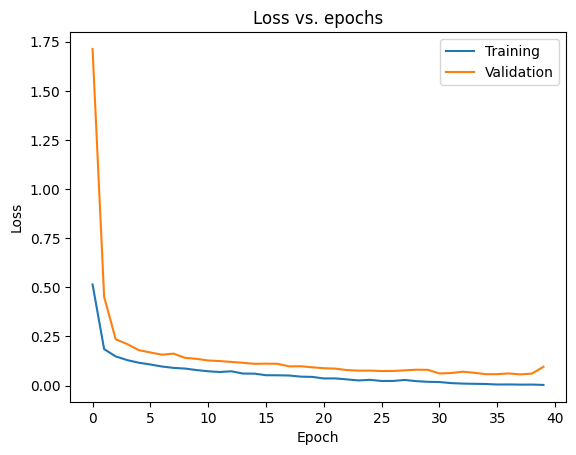

In [94]:
# Plot the training and validation loss

plt.plot(history_best.history['loss'])
plt.plot(history_best.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

<Axes: >

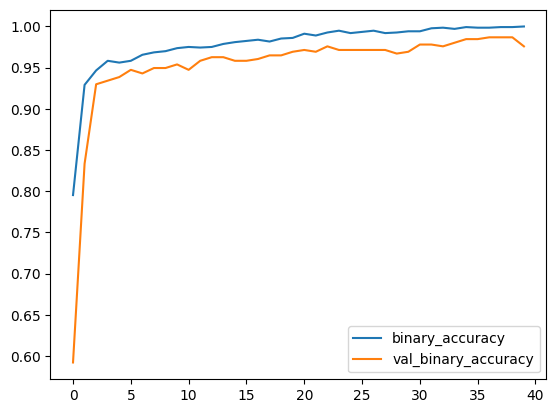

In [95]:
# Plot accuracy curves

df_best.plot(y=['binary_accuracy', 'val_binary_accuracy'])